# Libraries and Helper Functions

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def model_evaluation(y, predictions, probabilities, label, scores_df):
    class_labels = ['Not Readmitted', 'Readmitted']
    #calculate accuracy
    accuracy = accuracy_score(y, predictions)
    print('{0} Accuracy: {1:.4f}'.format(label, accuracy))
    #calculate precision
    precision = precision_score(y, predictions)
    print('{0} Precision: {1:.4f}'.format(label, precision))
    #calculate recall
    recall = recall_score(y, predictions)
    print('{0} Recall: {1:.4f}'.format(label, recall))
    #calculate f1
    f1 = f1_score(y, predictions)
    print('{0} F1: {1:.4f}'.format(label, f1))
    #calculate AUC
    fpr, tpr, thresholds = roc_curve(y, probabilities)
    roc_auc = auc(fpr, tpr)
    print('{0} AUC: {1:.4f}'.format(label, roc_auc))
    #plot confusion matrix
    cm = confusion_matrix(y, predictions)
    df_cm = np.transpose( np.transpose(cm) / cm.astype(np.float).sum(axis=1) )
    df_cm = pd.DataFrame(df_cm, index = class_labels, columns = class_labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    scores_df_add = pd.DataFrame([[label, accuracy, precision, recall, f1, roc_auc]],
                             columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
    scores_df = pd.concat([scores_df, scores_df_add])
    return scores_df

In [3]:
def get_feature_importance(feature_importance, features):
    indices = np.argsort(feature_importance)[::-1]
    feature_importance = [feature_importance[i] for i in indices]
    features = [features[i] for i in indices]
    features_index = range(1, len(features) + 1)
    num_features = len(features)
    plt.figure(figsize=(20,20))
    plt.bar(features_index[:num_features], feature_importance[:num_features], align = 'center')
    plt.xticks(features_index[:num_features], features[:num_features], rotation = 'vertical')
    plt.show()

# Load Model Results

In [4]:
parameters_df = pd.read_csv('model_parameters_dataset.csv')
feature_importance_df = pd.read_csv('model_feature_importance_dataset.csv')
train_predictions_df = pd.read_csv('model_train_predictions_dataset.csv')
test_predictions_df = pd.read_csv('model_test_predictions_dataset.csv')

scores_df = pd.DataFrame()

# Best Model Parameters

In [5]:
for i in range(parameters_df.shape[0]):
    print('{0} = {1}'.format(parameters_df.iloc[i]['Name'], parameters_df.iloc[i]['Best Parameters']))
    print('\n')

Logistic Regression = {'penalty': 'l1', 'C': 10.0, 'random_state': 42, 'class_weight': 'balanced'}


XGBoost = {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 1, 'reg_lambda': 1, 'seed': 42, 'objective': 'binary:logistic', 'max_depth': 3, 'gamma': 0}


Random Forest Top 40 = {'min_samples_leaf': 100, 'n_estimators': 1000, 'random_state': 42, 'max_features': 0.3, 'max_depth': 100, 'class_weight': 'balanced'}


Random Forest Top 60 = {'min_samples_leaf': 100, 'n_estimators': 1000, 'random_state': 42, 'max_features': 0.3, 'max_depth': 100, 'class_weight': 'balanced'}


Random Forest Top 70 = {'min_samples_leaf': 100, 'n_estimators': 1000, 'random_state': 42, 'max_features': 0.3, 'max_depth': 100, 'class_weight': 'balanced'}


Random Forest Top 50 = {'min_samples_leaf': 100, 'n_estimators': 1000, 'random_state': 42, 'max_features': 0.3, 'max_depth': 100, 'class_weight': 'balanced'}


Random Forest Top 10 = {'min_samples_leaf': 10, 

# Individual Model Results

## Blind Guess Models

### No Readmission

Blind Guess None - Train Accuracy: 0.8235
Blind Guess None - Train Precision: 0.0000
Blind Guess None - Train Recall: 0.0000
Blind Guess None - Train F1: 0.0000
Blind Guess None - Train AUC: 0.5000


/Users/ipatel/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ipatel/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


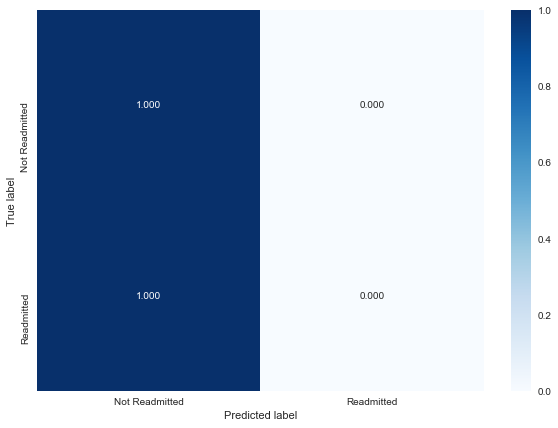

Blind Guess None - Test Accuracy: 0.8175
Blind Guess None - Test Precision: 0.0000
Blind Guess None - Test Recall: 0.0000
Blind Guess None - Test F1: 0.0000
Blind Guess None - Test AUC: 0.5000


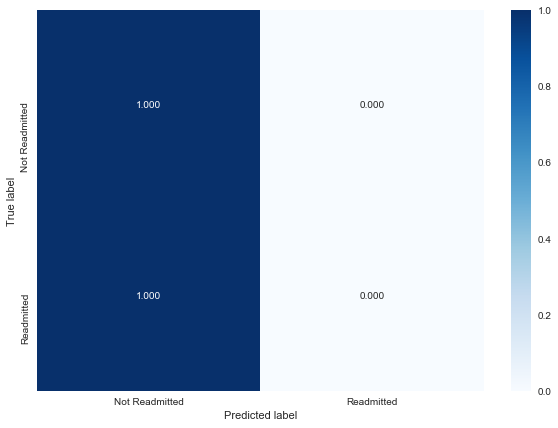

In [6]:
model_name = 'Blind Guess None'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

### Readmission

Blind Guess All - Train Accuracy: 0.1765
Blind Guess All - Train Precision: 0.1765
Blind Guess All - Train Recall: 1.0000
Blind Guess All - Train F1: 0.3000
Blind Guess All - Train AUC: 0.5000


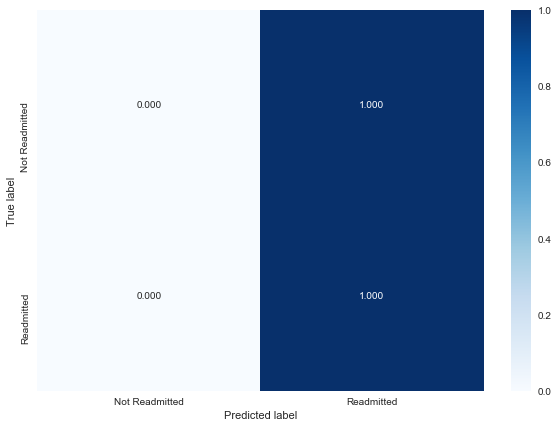

Blind Guess All - Test Accuracy: 0.1825
Blind Guess All - Test Precision: 0.1825
Blind Guess All - Test Recall: 1.0000
Blind Guess All - Test F1: 0.3086
Blind Guess All - Test AUC: 0.5000


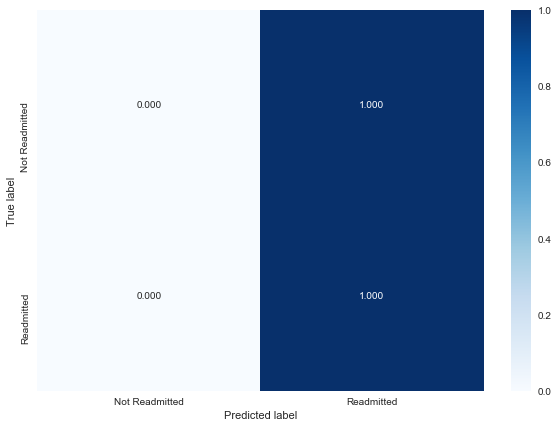

In [7]:
model_name = 'Blind Guess All'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

# Logistic Regression

Logistic Regression - Train Accuracy: 0.6153
Logistic Regression - Train Precision: 0.2851
Logistic Regression - Train Recall: 0.7827
Logistic Regression - Train F1: 0.4180
Logistic Regression - Train AUC: 0.7414


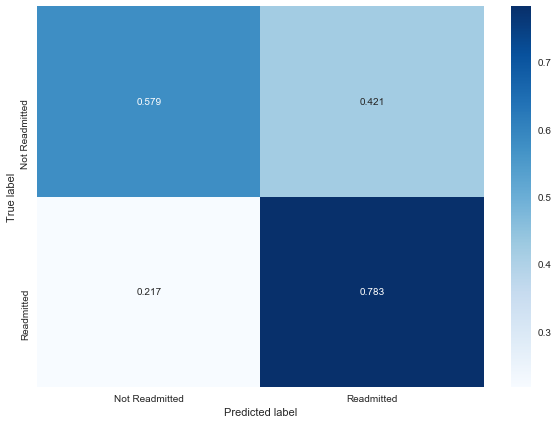

Logistic Regression - Test Accuracy: 0.6082
Logistic Regression - Test Precision: 0.2898
Logistic Regression - Test Recall: 0.7905
Logistic Regression - Test F1: 0.4241
Logistic Regression - Test AUC: 0.7423


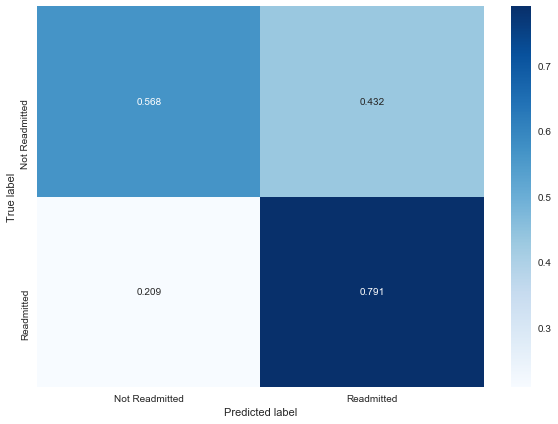

In [8]:
model_name = 'Logistic Regression'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

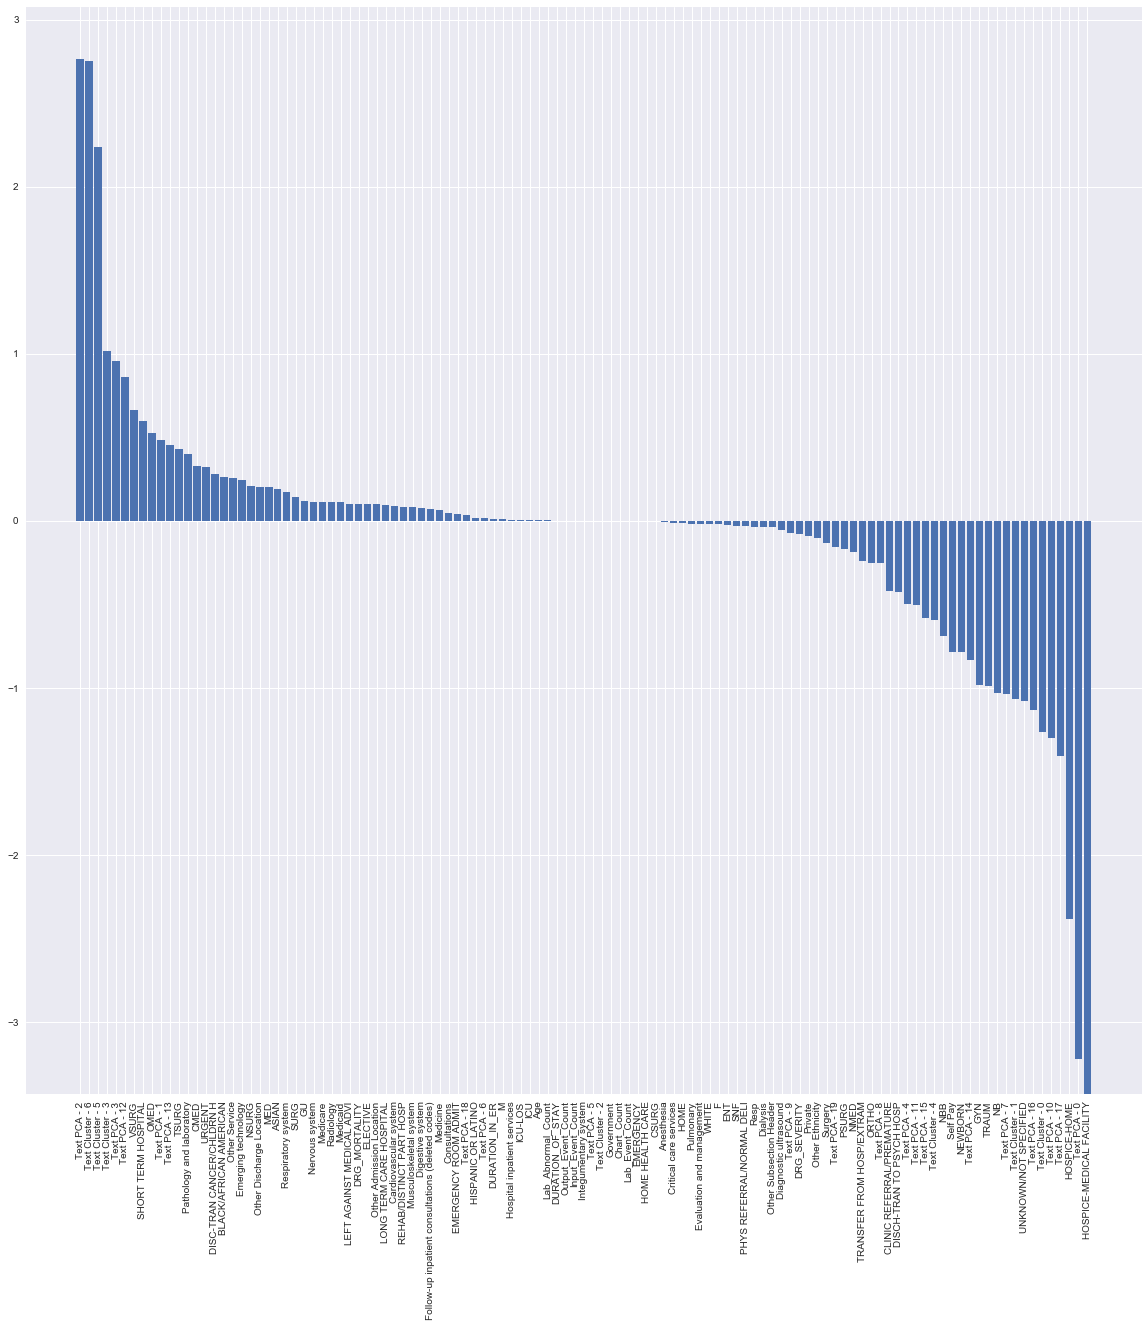

In [9]:
get_feature_importance(feature_importance_df[model_name], feature_importance_df['Features'])

## Random Forest

### All Features

Random Forest All - Train Accuracy: 0.8496
Random Forest All - Train Precision: 0.5472
Random Forest All - Train Recall: 0.8560
Random Forest All - Train F1: 0.6676
Random Forest All - Train AUC: 0.9300


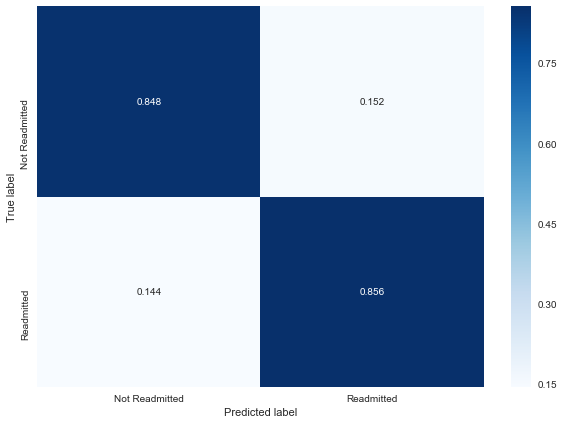

Random Forest All - Test Accuracy: 0.7566
Random Forest All - Test Precision: 0.3899
Random Forest All - Test Recall: 0.5908
Random Forest All - Test F1: 0.4697
Random Forest All - Test AUC: 0.7894


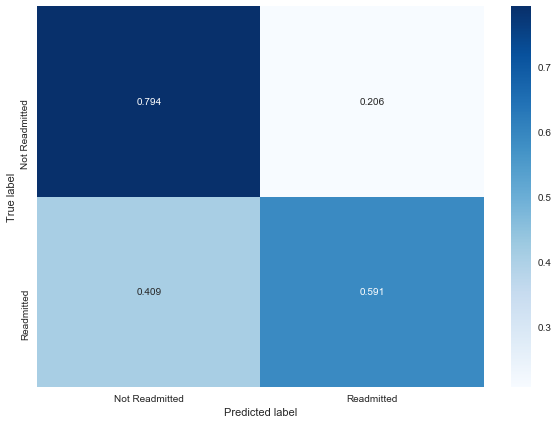

In [10]:
model_name = 'Random Forest All'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

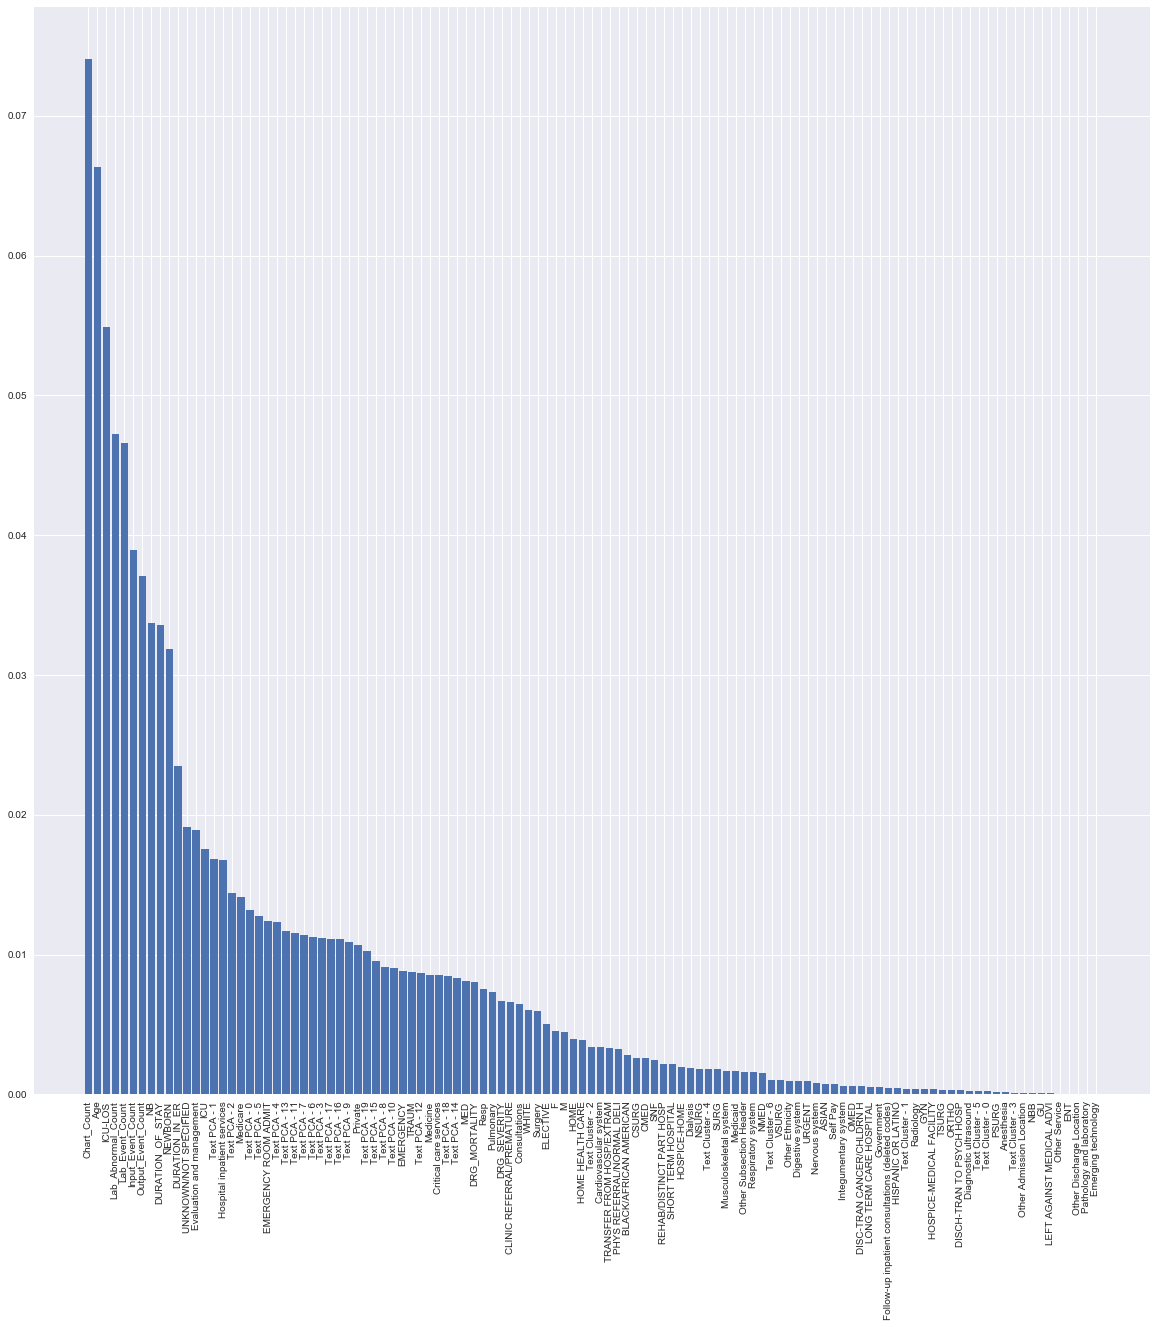

In [11]:
get_feature_importance(feature_importance_df[model_name], feature_importance_df['Features'])

### Top 10 Features

Random Forest Top 10 - Train Accuracy: 0.6989
Random Forest Top 10 - Train Precision: 0.3363
Random Forest Top 10 - Train Recall: 0.7257
Random Forest Top 10 - Train F1: 0.4596
Random Forest Top 10 - Train AUC: 0.8078


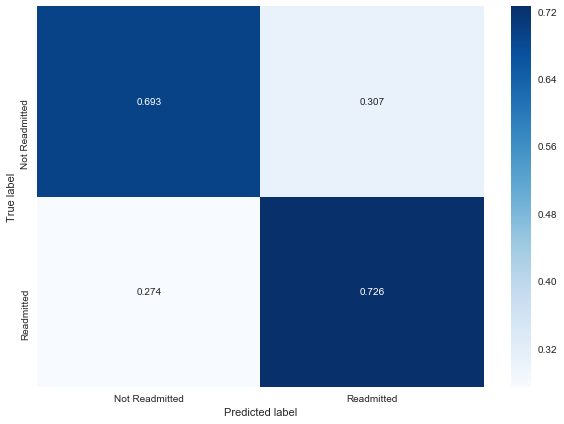

Random Forest Top 10 - Test Accuracy: 0.6829
Random Forest Top 10 - Test Precision: 0.3240
Random Forest Top 10 - Test Recall: 0.6792
Random Forest Top 10 - Test F1: 0.4387
Random Forest Top 10 - Test AUC: 0.7541


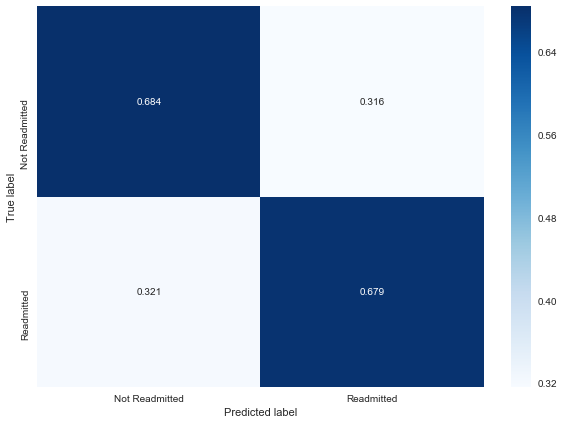

In [12]:
model_name = 'Random Forest Top 10'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

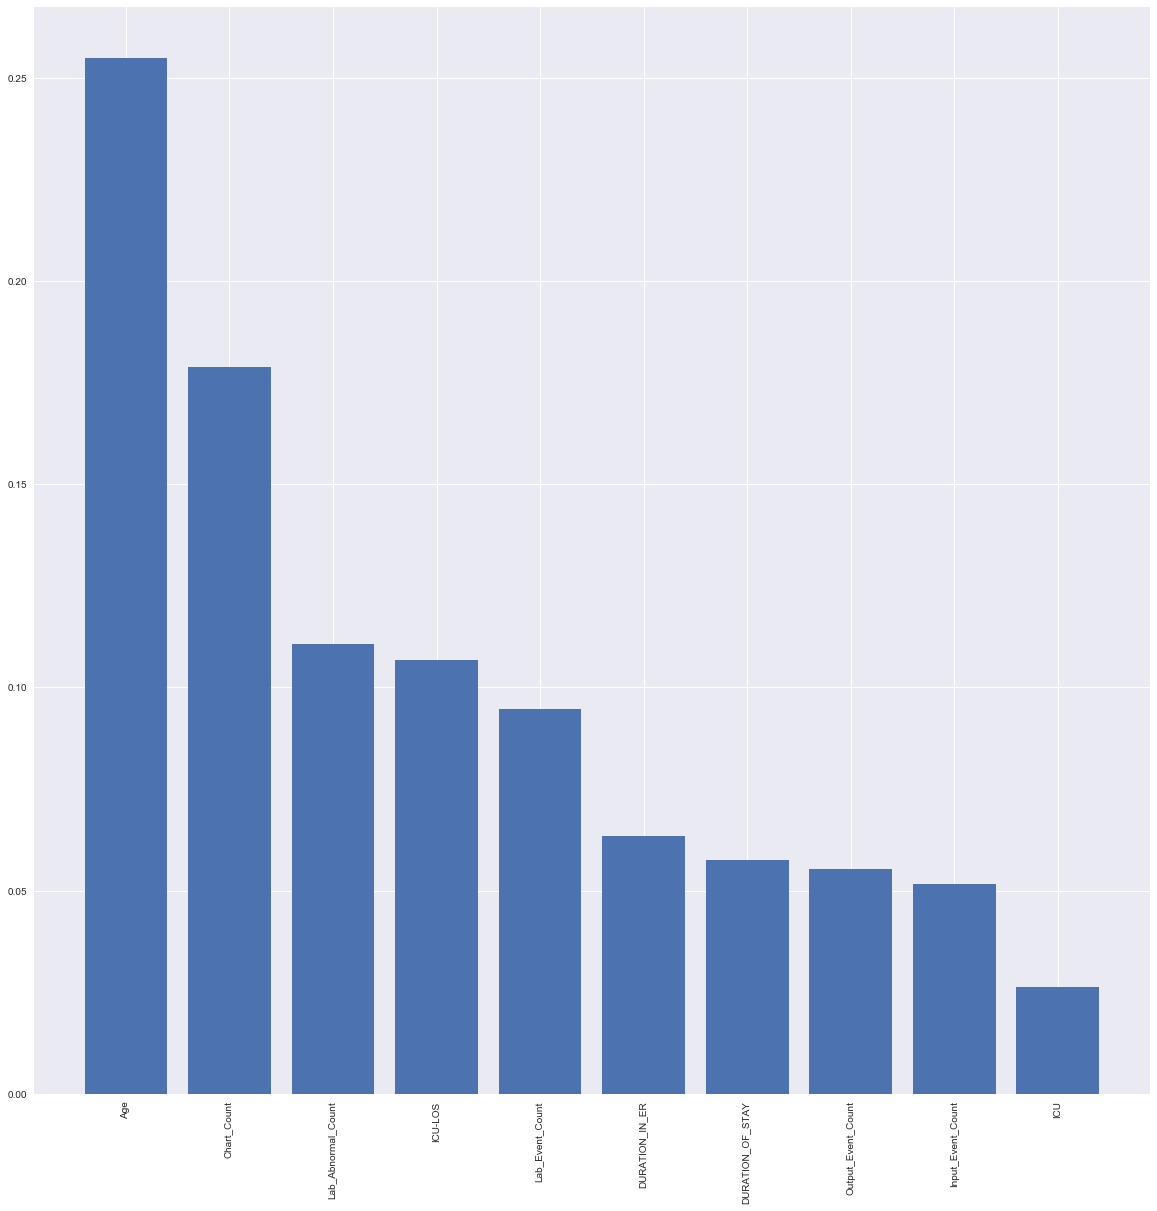

In [13]:
feature_importance_subdf = feature_importance_df[feature_importance_df[model_name].notnull()]
feature_importance_subdf = feature_importance_subdf.reset_index()
get_feature_importance(feature_importance_subdf[model_name], feature_importance_subdf['Features'])

### Top 20 Features

Random Forest Top 20 - Train Accuracy: 0.6716
Random Forest Top 20 - Train Precision: 0.3245
Random Forest Top 20 - Train Recall: 0.7957
Random Forest Top 20 - Train F1: 0.4610
Random Forest Top 20 - Train AUC: 0.8055


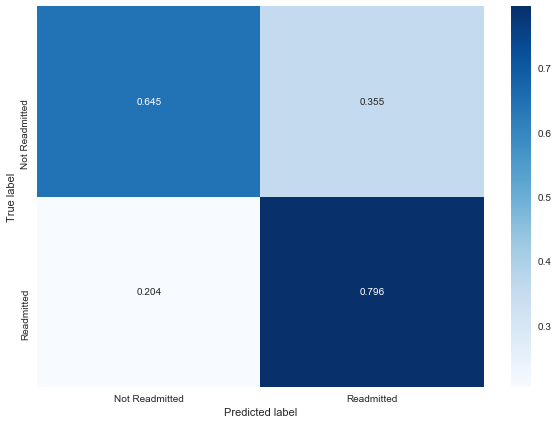

Random Forest Top 20 - Test Accuracy: 0.6542
Random Forest Top 20 - Test Precision: 0.3139
Random Forest Top 20 - Test Recall: 0.7547
Random Forest Top 20 - Test F1: 0.4433
Random Forest Top 20 - Test AUC: 0.7722


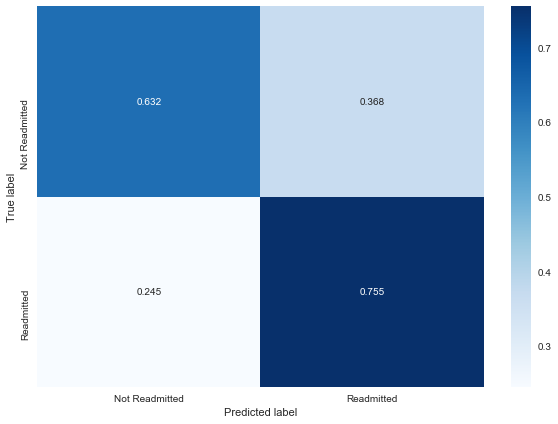

In [14]:
model_name = 'Random Forest Top 20'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

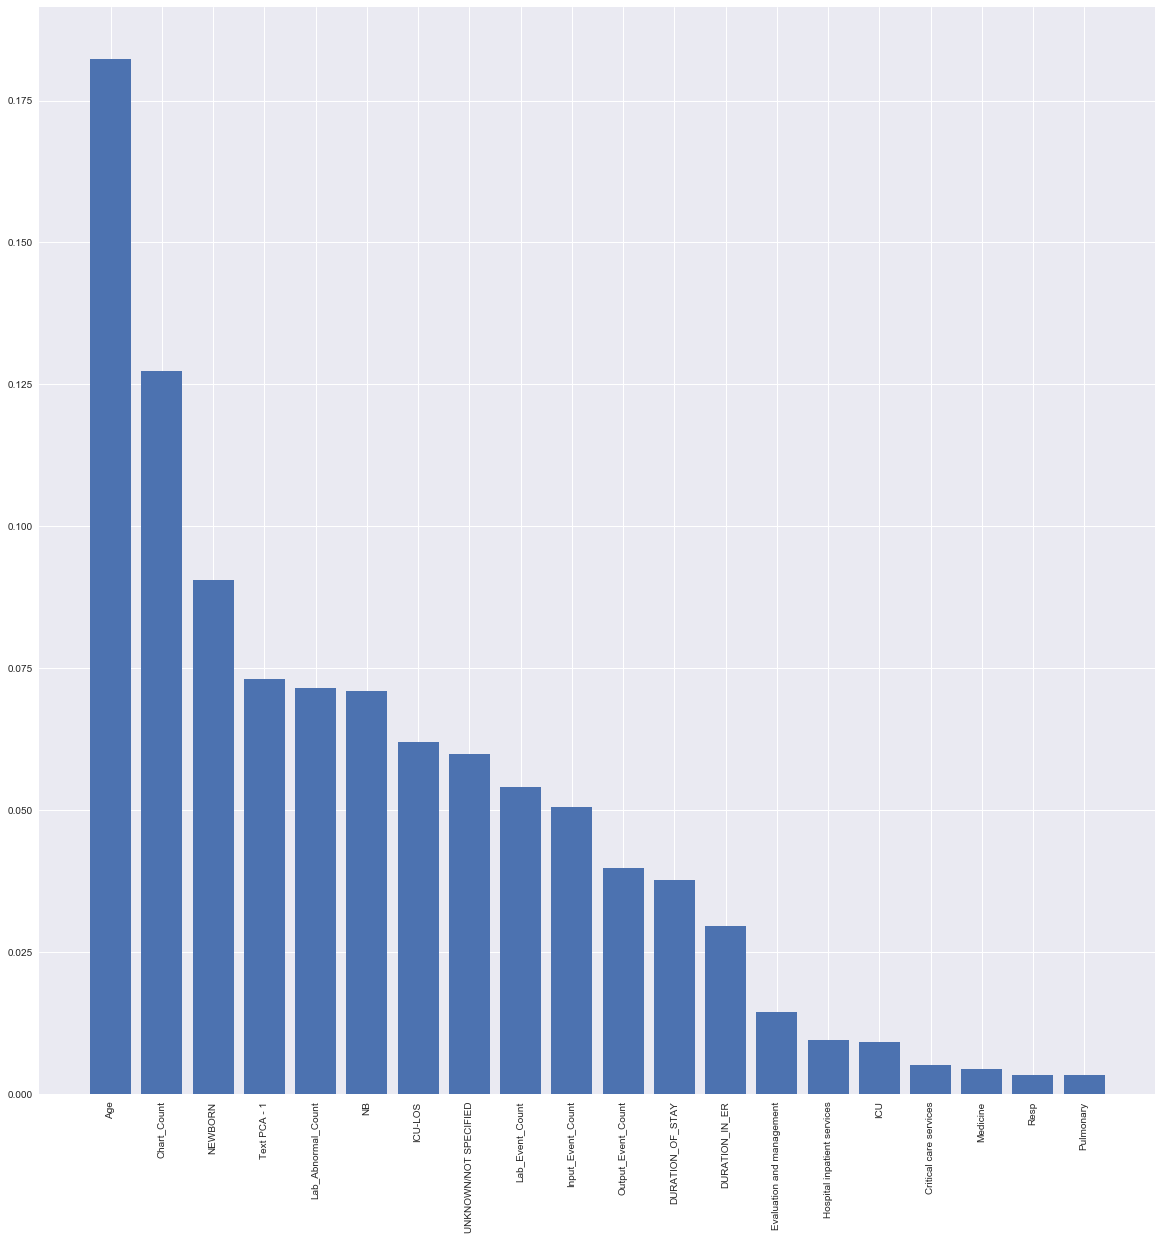

In [15]:
feature_importance_subdf = feature_importance_df[feature_importance_df[model_name].notnull()]
feature_importance_subdf = feature_importance_subdf.reset_index()
get_feature_importance(feature_importance_subdf[model_name], feature_importance_subdf['Features'])

### Top 30 Features

Random Forest Top 30 - Train Accuracy: 0.6688
Random Forest Top 30 - Train Precision: 0.3232
Random Forest Top 30 - Train Recall: 0.8012
Random Forest Top 30 - Train F1: 0.4606
Random Forest Top 30 - Train AUC: 0.8114


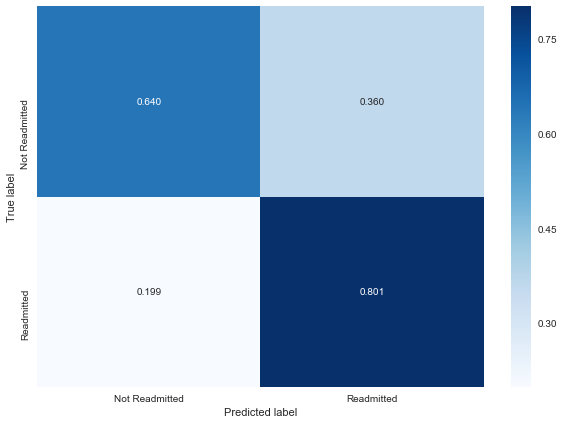

Random Forest Top 30 - Test Accuracy: 0.6544
Random Forest Top 30 - Test Precision: 0.3174
Random Forest Top 30 - Test Recall: 0.7768
Random Forest Top 30 - Test F1: 0.4507
Random Forest Top 30 - Test AUC: 0.7765


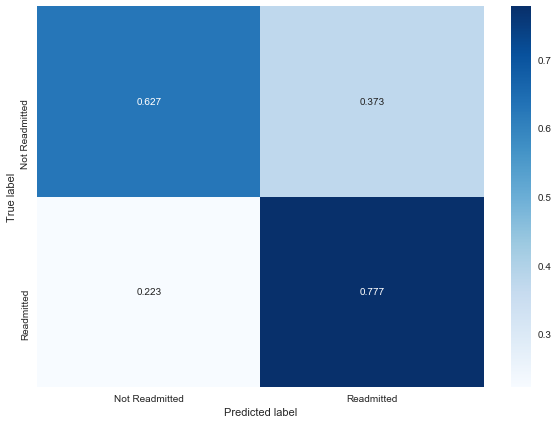

In [16]:
model_name = 'Random Forest Top 30'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

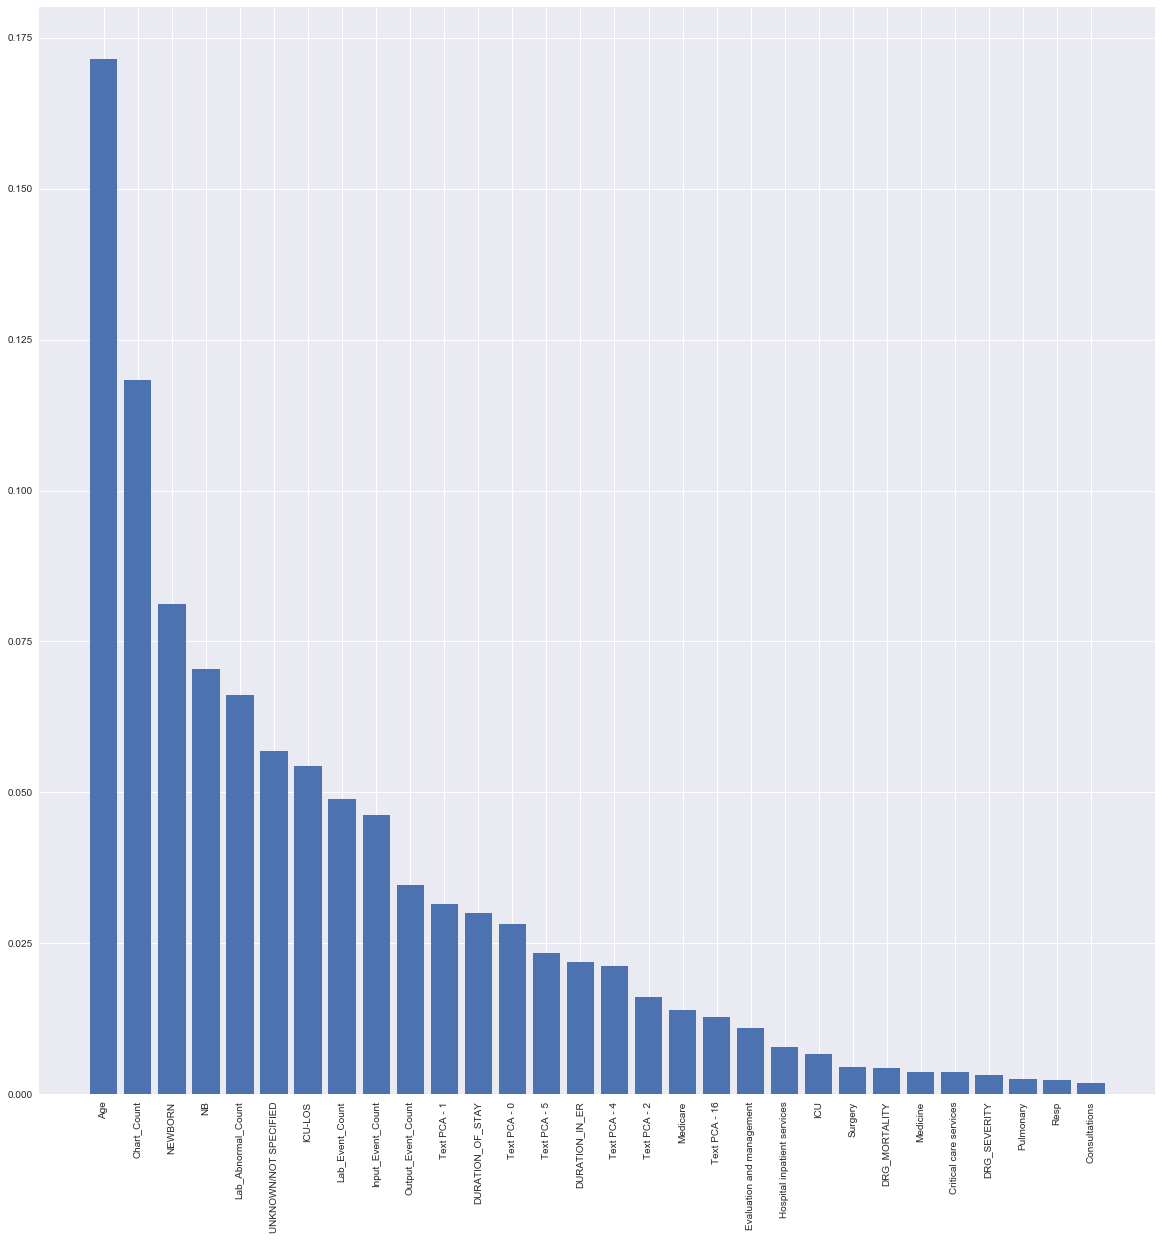

In [17]:
feature_importance_subdf = feature_importance_df[feature_importance_df[model_name].notnull()]
feature_importance_subdf = feature_importance_subdf.reset_index()
get_feature_importance(feature_importance_subdf[model_name], feature_importance_subdf['Features'])

### Random Forest Top 40

Random Forest Top 40 - Train Accuracy: 0.6735
Random Forest Top 40 - Train Precision: 0.3269
Random Forest Top 40 - Train Recall: 0.8024
Random Forest Top 40 - Train F1: 0.4645
Random Forest Top 40 - Train AUC: 0.8140


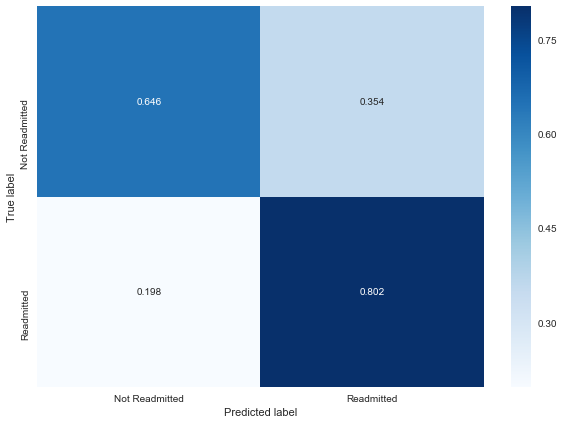

Random Forest Top 40 - Test Accuracy: 0.6538
Random Forest Top 40 - Test Precision: 0.3163
Random Forest Top 40 - Test Recall: 0.7723
Random Forest Top 40 - Test F1: 0.4488
Random Forest Top 40 - Test AUC: 0.7780


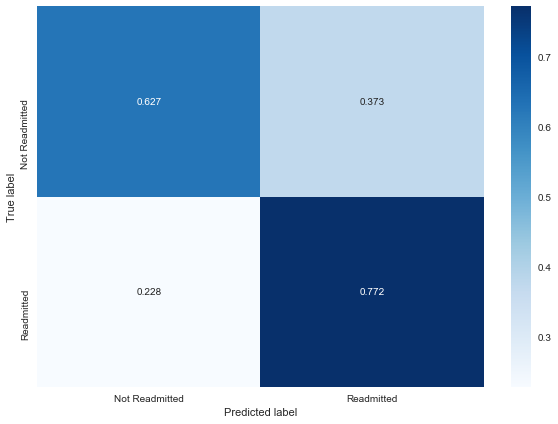

In [18]:
model_name = 'Random Forest Top 40'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

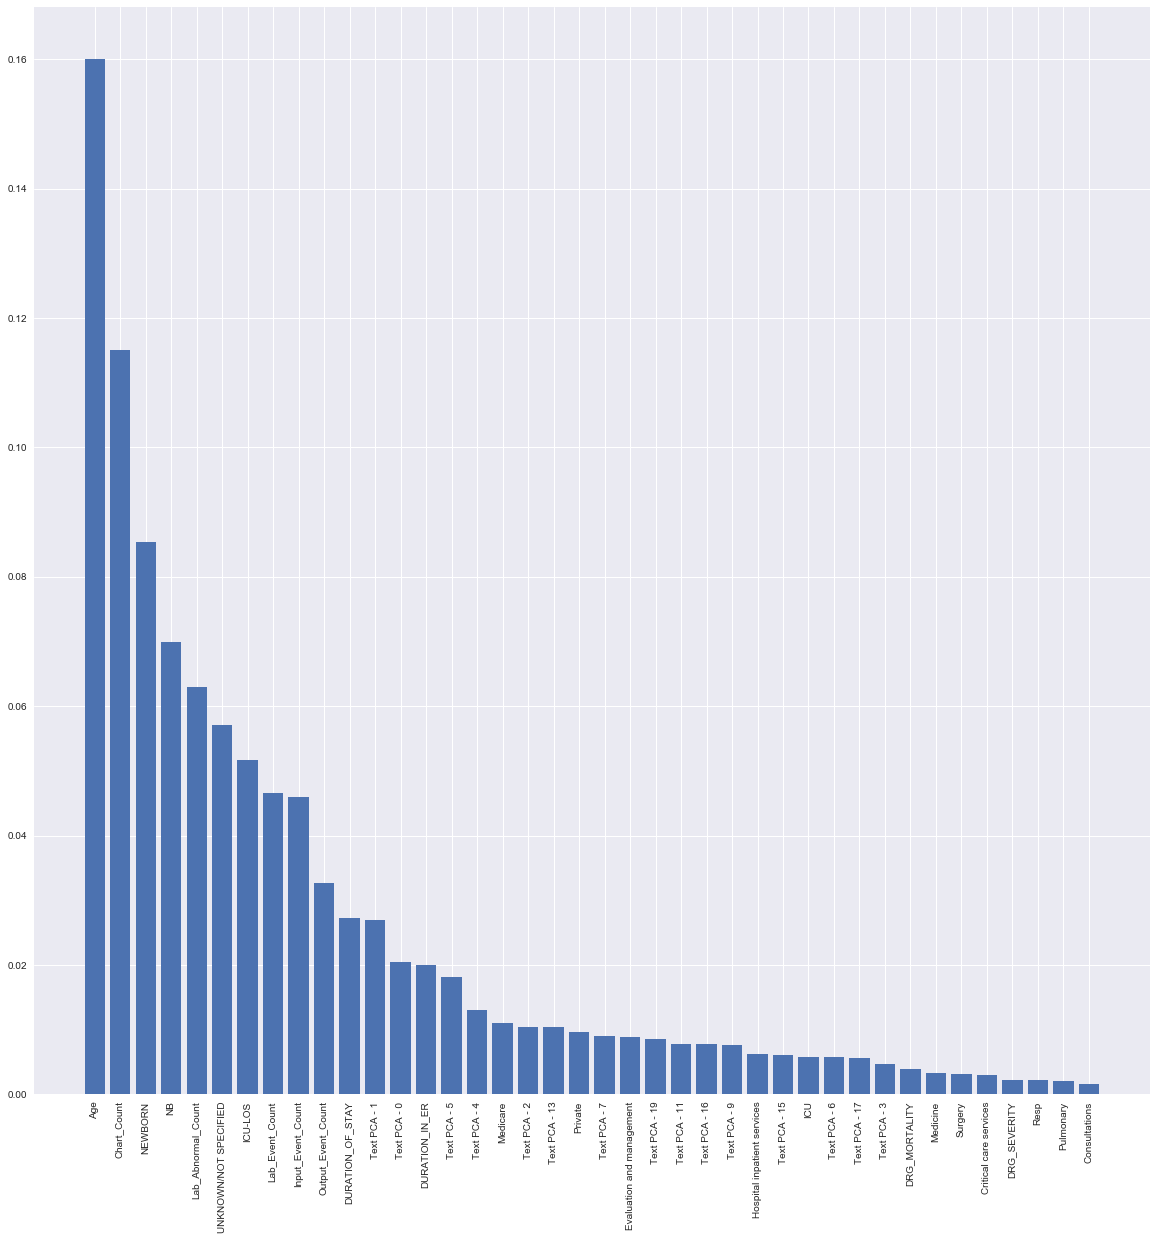

In [19]:
feature_importance_subdf = feature_importance_df[feature_importance_df[model_name].notnull()]
feature_importance_subdf = feature_importance_subdf.reset_index()
get_feature_importance(feature_importance_subdf[model_name], feature_importance_subdf['Features'])

### Random Forest Top 50

Random Forest Top 50 - Train Accuracy: 0.6865
Random Forest Top 50 - Train Precision: 0.3364
Random Forest Top 50 - Train Recall: 0.7982
Random Forest Top 50 - Train F1: 0.4733
Random Forest Top 50 - Train AUC: 0.8157


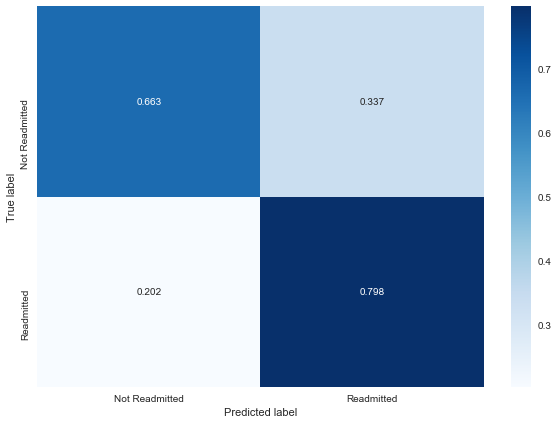

Random Forest Top 50 - Test Accuracy: 0.6654
Random Forest Top 50 - Test Precision: 0.3233
Random Forest Top 50 - Test Recall: 0.7625
Random Forest Top 50 - Test F1: 0.4541
Random Forest Top 50 - Test AUC: 0.7817


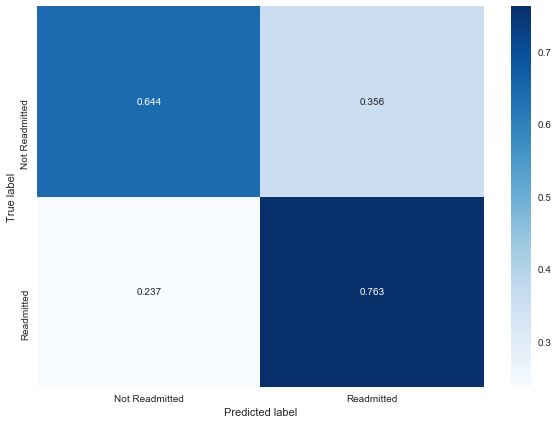

In [20]:
model_name = 'Random Forest Top 50'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

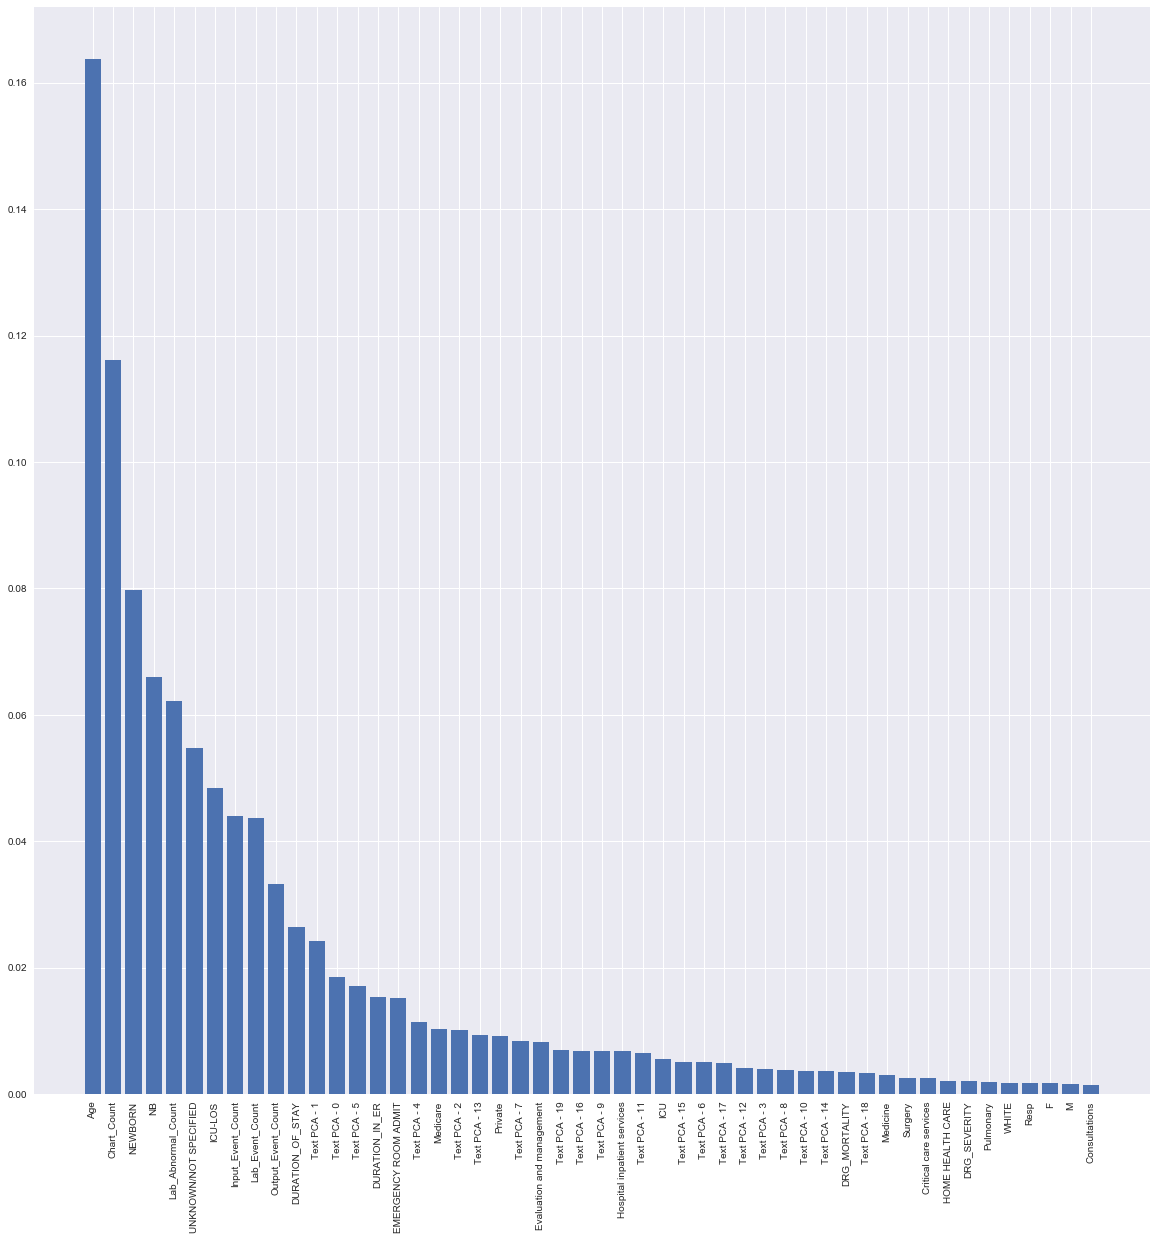

In [21]:
feature_importance_subdf = feature_importance_df[feature_importance_df[model_name].notnull()]
feature_importance_subdf = feature_importance_subdf.reset_index()
get_feature_importance(feature_importance_subdf[model_name], feature_importance_subdf['Features'])

### Random Forest Top 60

Random Forest Top 60 - Train Accuracy: 0.6902
Random Forest Top 60 - Train Precision: 0.3393
Random Forest Top 60 - Train Recall: 0.7973
Random Forest Top 60 - Train F1: 0.4760
Random Forest Top 60 - Train AUC: 0.8181


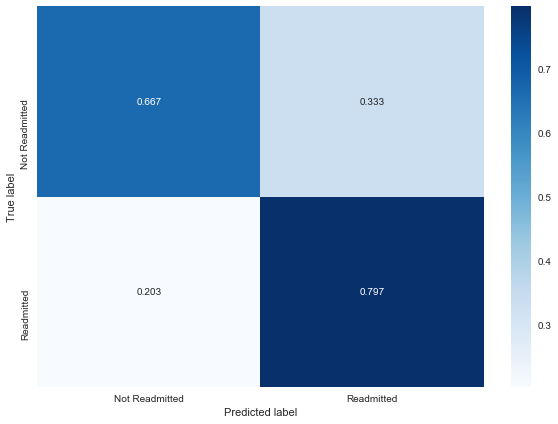

Random Forest Top 60 - Test Accuracy: 0.6703
Random Forest Top 60 - Test Precision: 0.3277
Random Forest Top 60 - Test Recall: 0.7671
Random Forest Top 60 - Test F1: 0.4592
Random Forest Top 60 - Test AUC: 0.7844


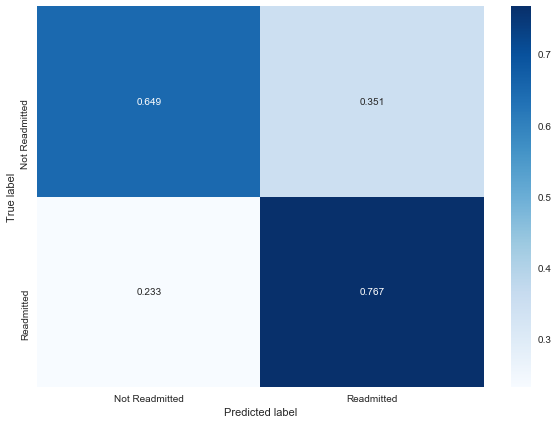

In [22]:
model_name = 'Random Forest Top 60'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

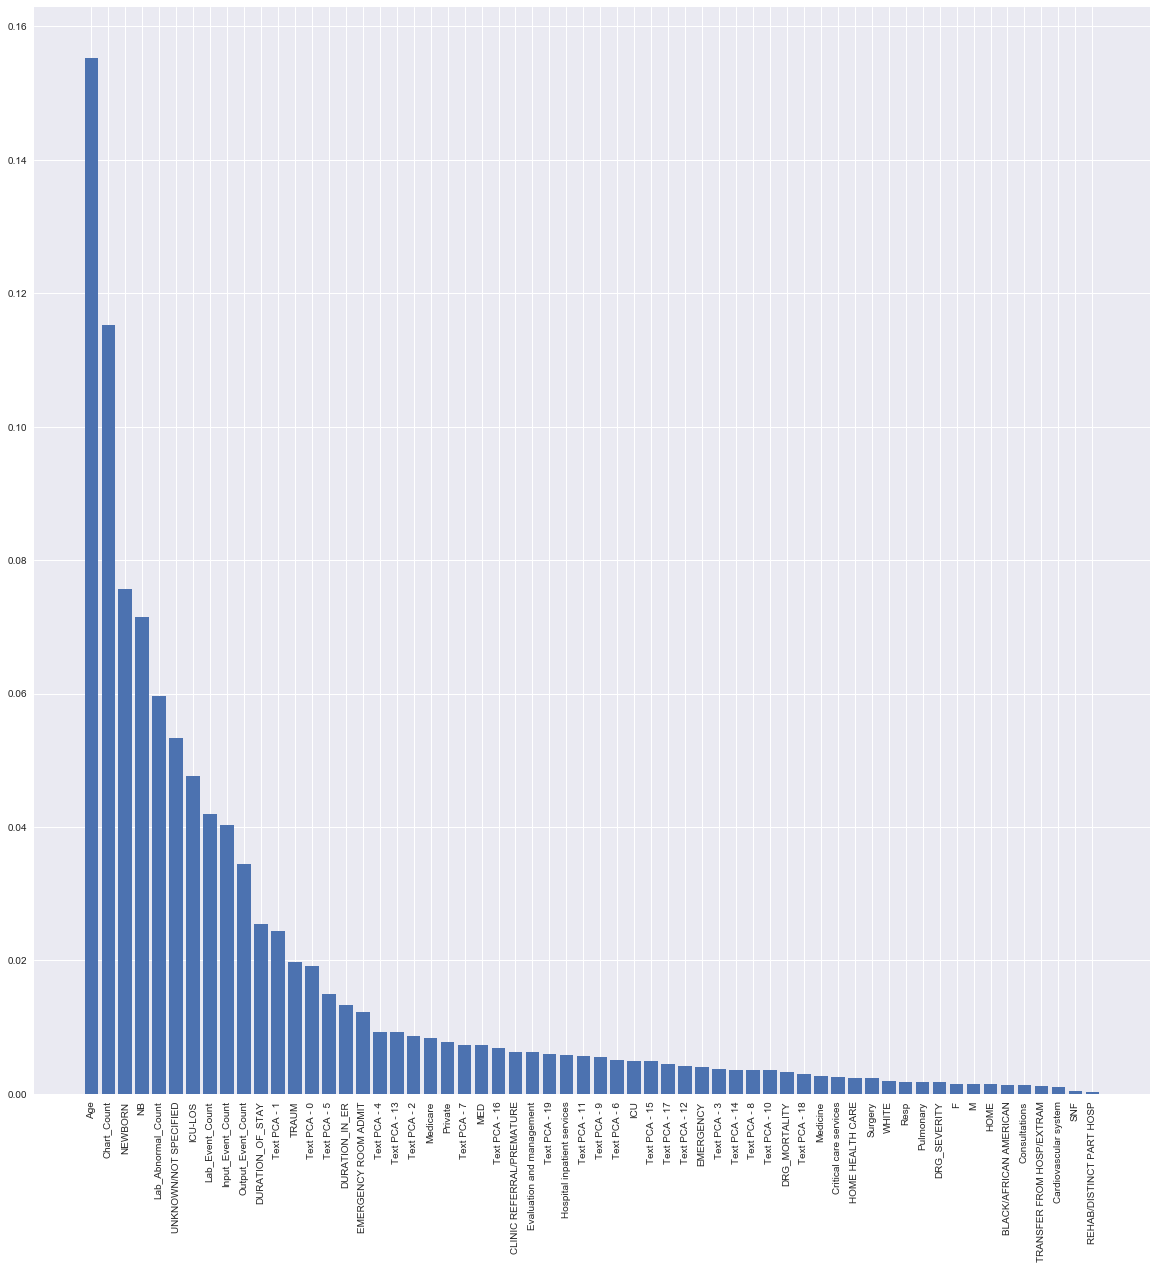

In [23]:
feature_importance_subdf = feature_importance_df[feature_importance_df[model_name].notnull()]
feature_importance_subdf = feature_importance_subdf.reset_index()
get_feature_importance(feature_importance_subdf[model_name], feature_importance_subdf['Features'])

### Random Forest Top 70

Random Forest Top 70 - Train Accuracy: 0.6908
Random Forest Top 70 - Train Precision: 0.3396
Random Forest Top 70 - Train Recall: 0.7965
Random Forest Top 70 - Train F1: 0.4762
Random Forest Top 70 - Train AUC: 0.8184


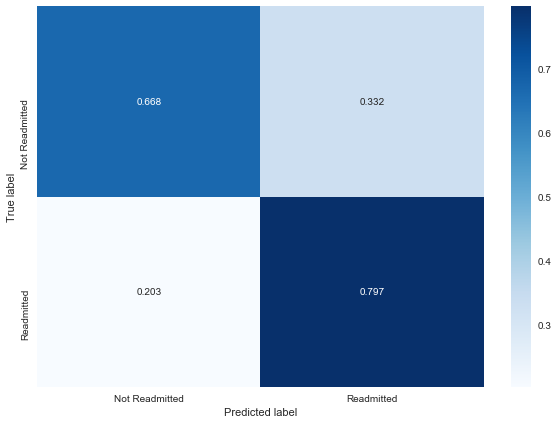

Random Forest Top 70 - Test Accuracy: 0.6688
Random Forest Top 70 - Test Precision: 0.3263
Random Forest Top 70 - Test Recall: 0.7658
Random Forest Top 70 - Test F1: 0.4576
Random Forest Top 70 - Test AUC: 0.7846


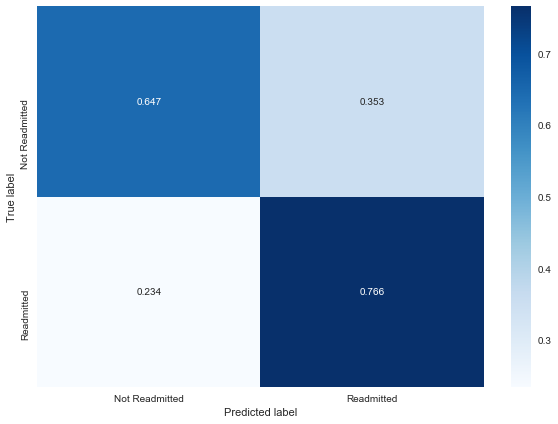

In [24]:
model_name = 'Random Forest Top 70'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

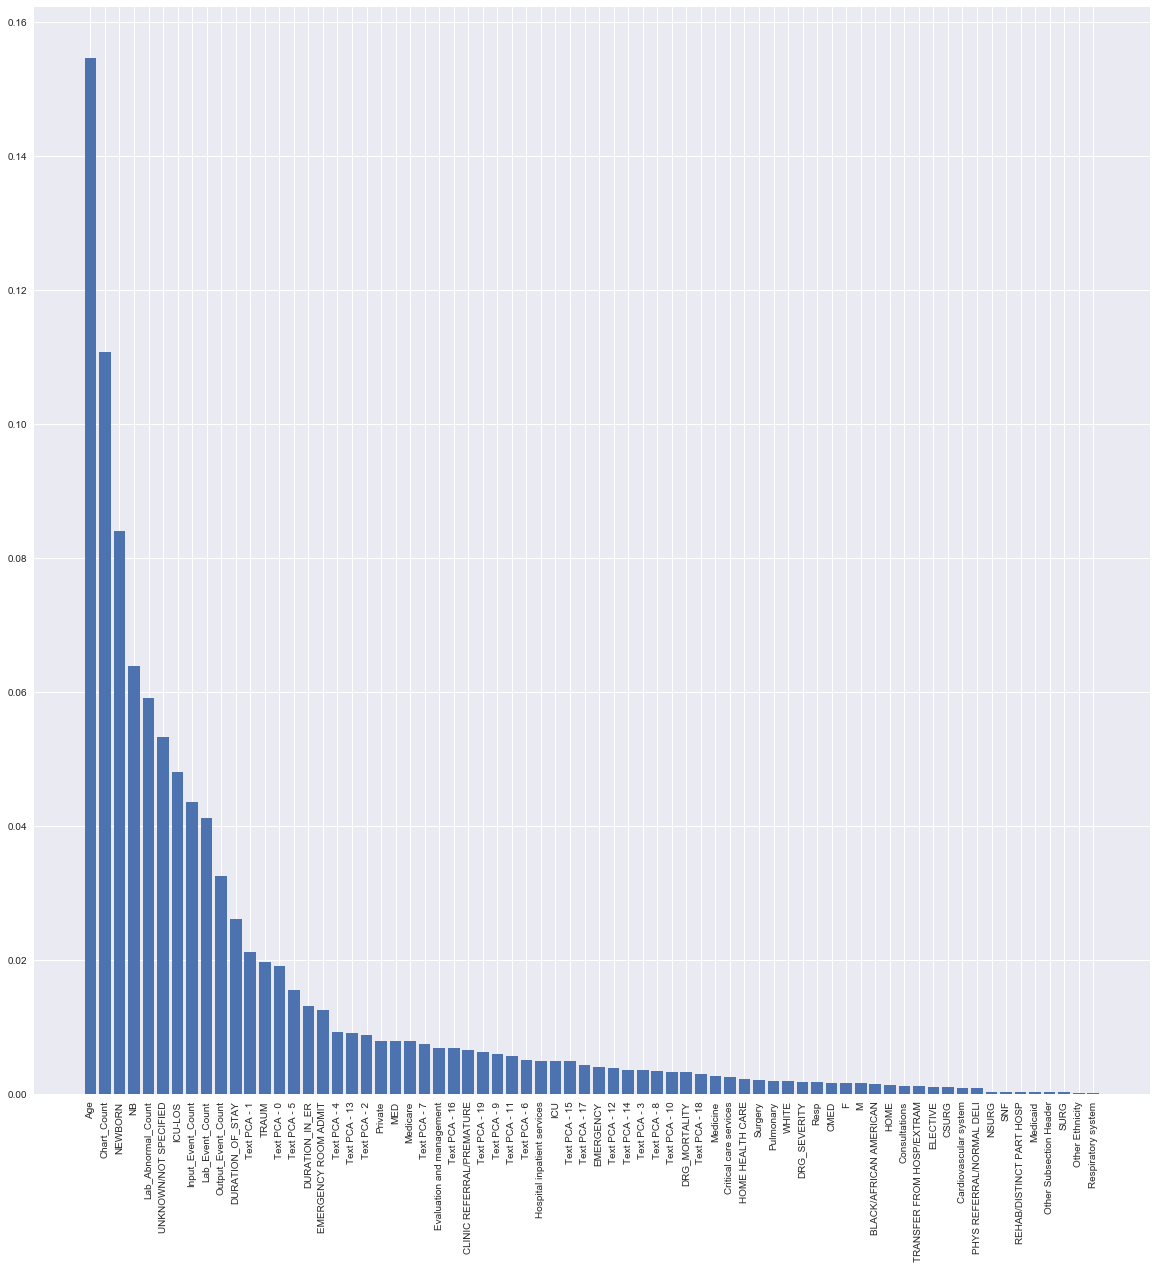

In [25]:
feature_importance_subdf = feature_importance_df[feature_importance_df[model_name].notnull()]
feature_importance_subdf = feature_importance_subdf.reset_index()
get_feature_importance(feature_importance_subdf[model_name], feature_importance_subdf['Features'])

### Random Forest Top 80

Random Forest Top 80 - Train Accuracy: 0.6904
Random Forest Top 80 - Train Precision: 0.3390
Random Forest Top 80 - Train Recall: 0.7943
Random Forest Top 80 - Train F1: 0.4752
Random Forest Top 80 - Train AUC: 0.8188


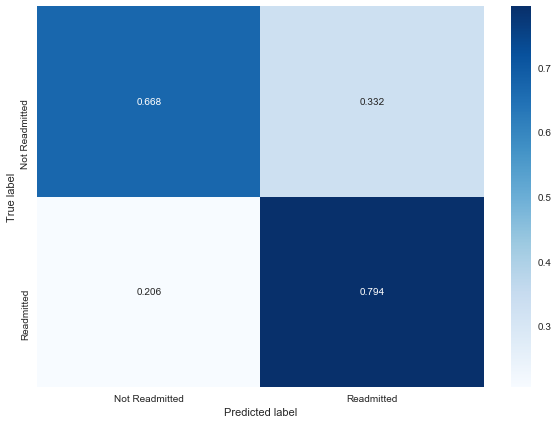

Random Forest Top 80 - Test Accuracy: 0.6702
Random Forest Top 80 - Test Precision: 0.3273
Random Forest Top 80 - Test Recall: 0.7651
Random Forest Top 80 - Test F1: 0.4585
Random Forest Top 80 - Test AUC: 0.7857


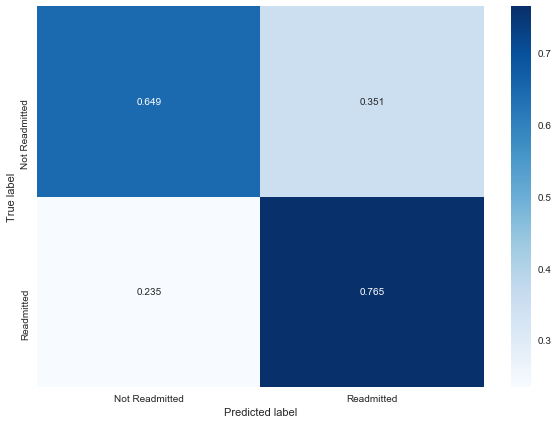

In [26]:
model_name = 'Random Forest Top 80'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

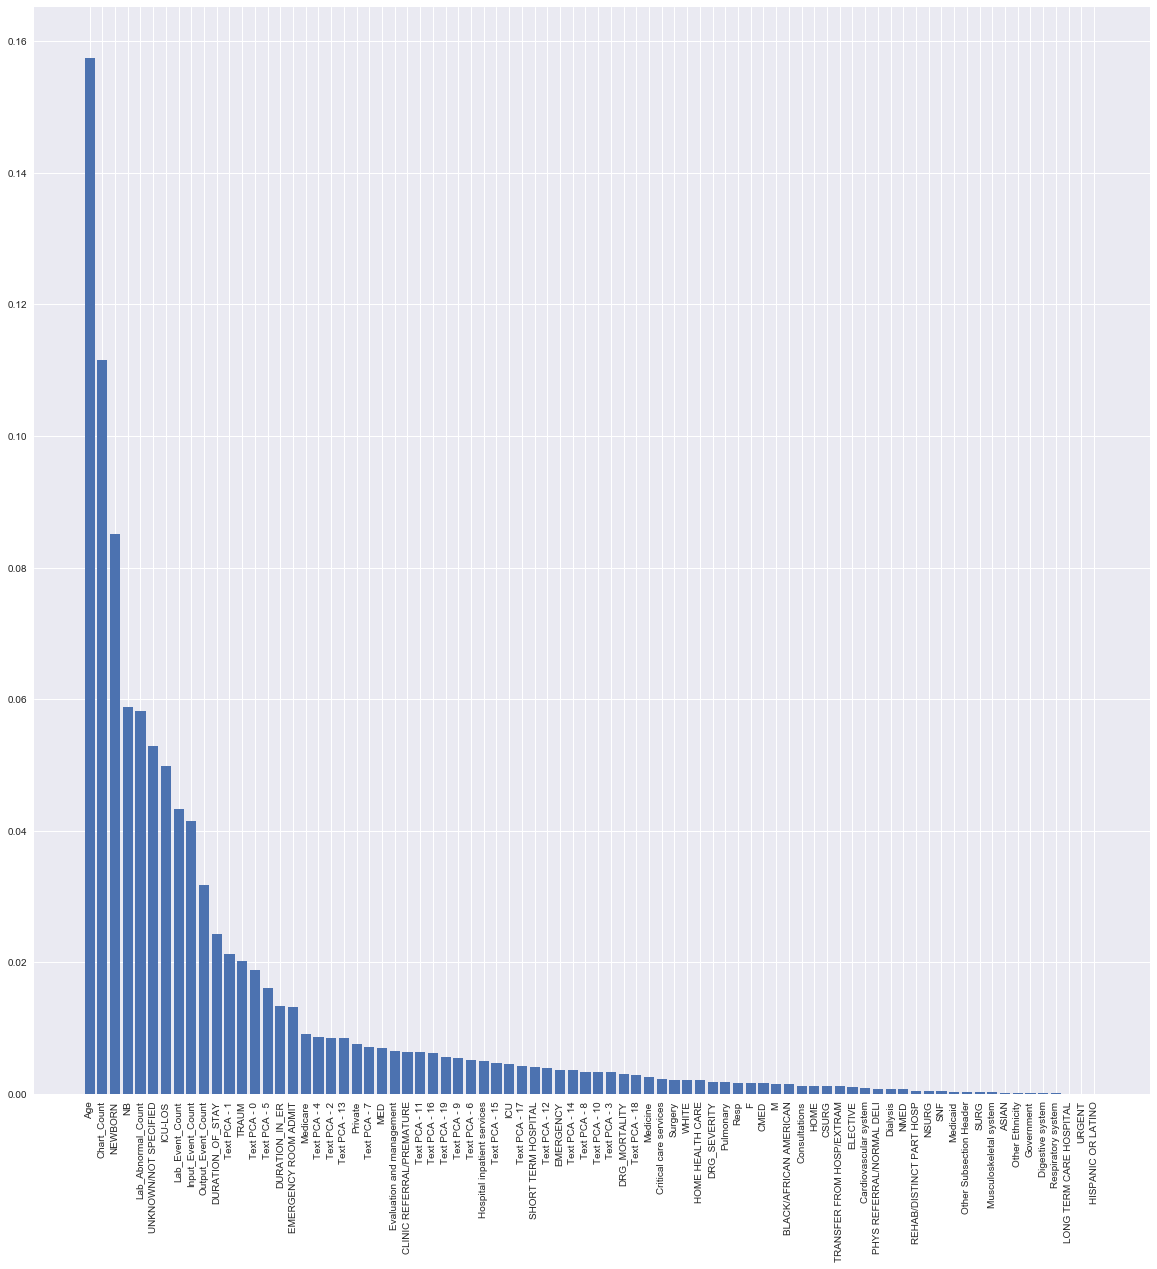

In [27]:
feature_importance_subdf = feature_importance_df[feature_importance_df[model_name].notnull()]
feature_importance_subdf = feature_importance_subdf.reset_index()
get_feature_importance(feature_importance_subdf[model_name], feature_importance_subdf['Features'])

### Random Forest Top 90

Random Forest Top 90 - Train Accuracy: 0.8705
Random Forest Top 90 - Train Precision: 0.5908
Random Forest Top 90 - Train Recall: 0.8663
Random Forest Top 90 - Train F1: 0.7025
Random Forest Top 90 - Train AUC: 0.9435


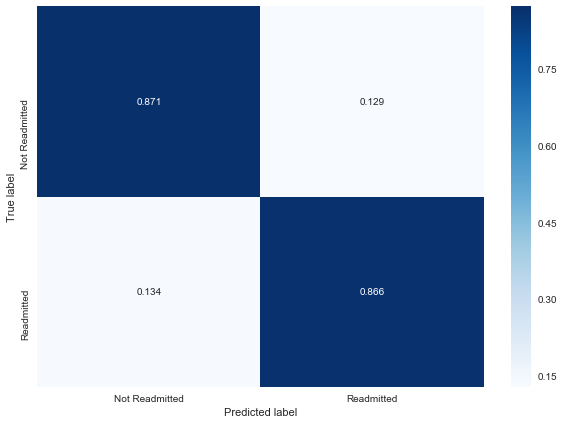

Random Forest Top 90 - Test Accuracy: 0.7678
Random Forest Top 90 - Test Precision: 0.4032
Random Forest Top 90 - Test Recall: 0.5680
Random Forest Top 90 - Test F1: 0.4716
Random Forest Top 90 - Test AUC: 0.7898


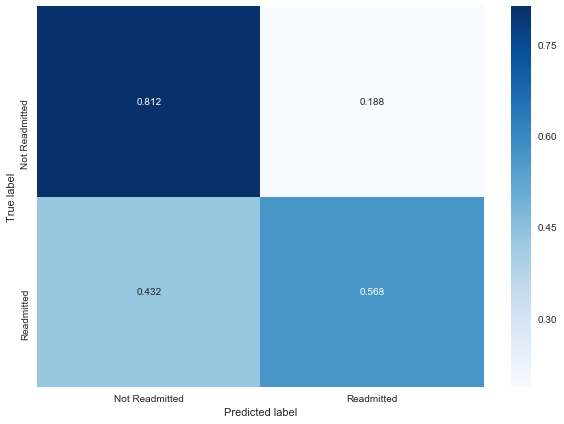

In [28]:
model_name = 'Random Forest Top 90'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

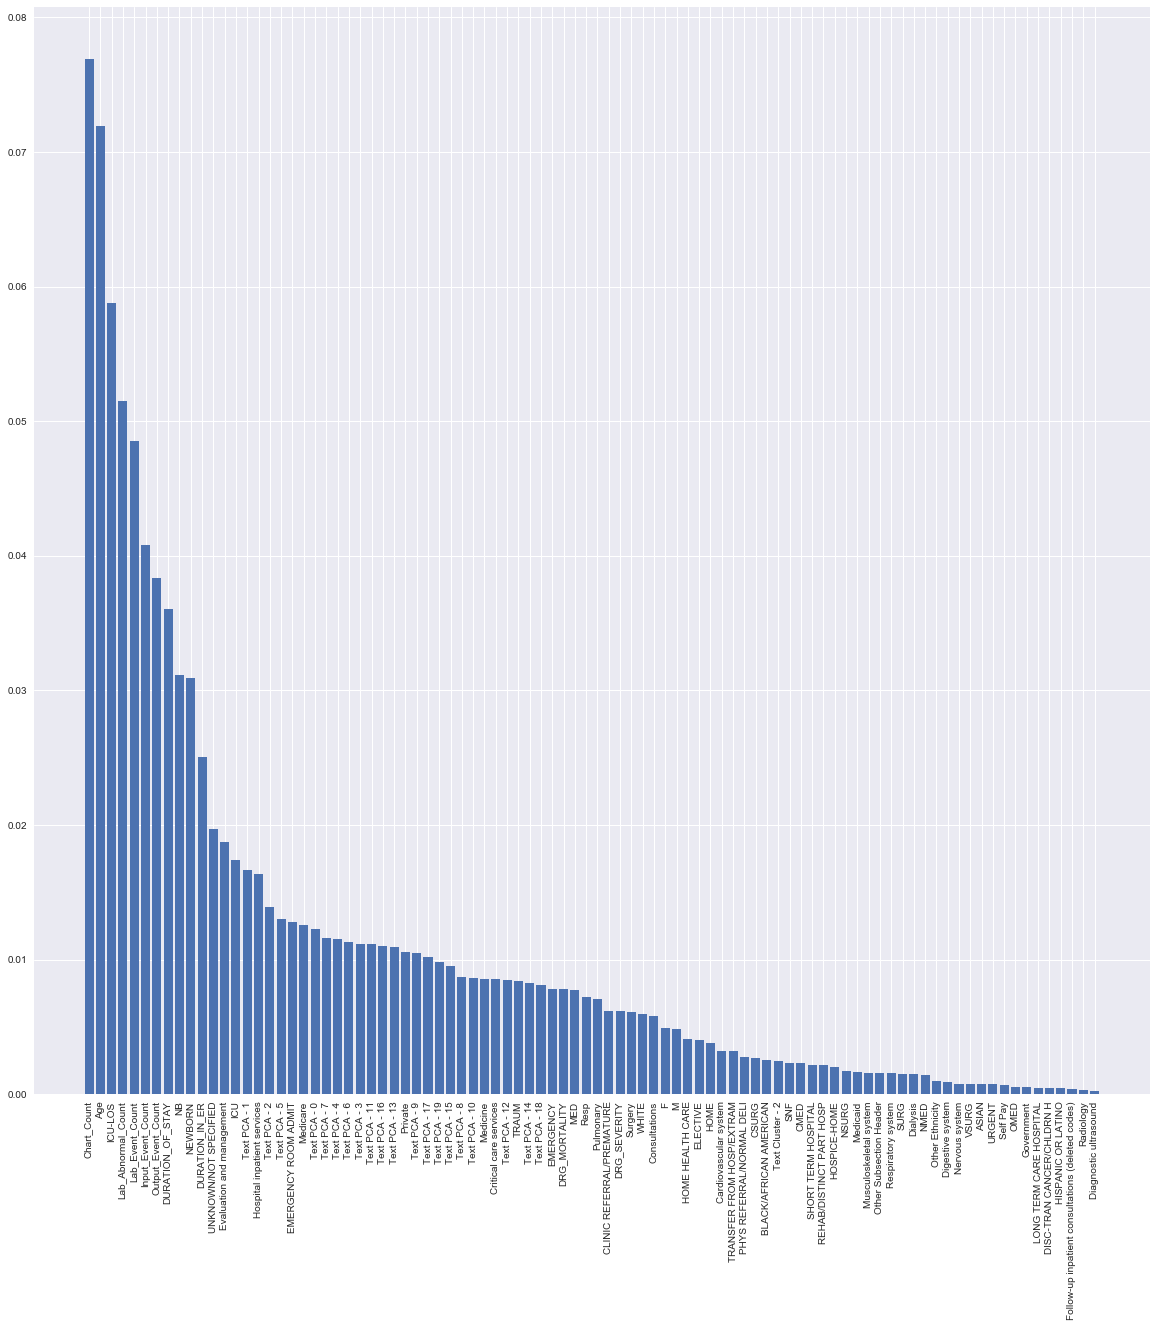

In [29]:
feature_importance_subdf = feature_importance_df[feature_importance_df[model_name].notnull()]
feature_importance_subdf = feature_importance_subdf.reset_index()
get_feature_importance(feature_importance_subdf[model_name], feature_importance_subdf['Features'])

### Random Forest Top 100

Random Forest Top 100 - Train Accuracy: 0.8616
Random Forest Top 100 - Train Precision: 0.5716
Random Forest Top 100 - Train Recall: 0.8618
Random Forest Top 100 - Train F1: 0.6873
Random Forest Top 100 - Train AUC: 0.9380


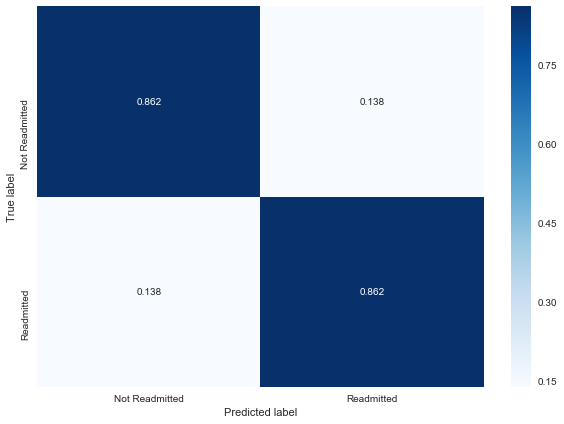

Random Forest Top 100 - Test Accuracy: 0.7621
Random Forest Top 100 - Test Precision: 0.3962
Random Forest Top 100 - Test Recall: 0.5797
Random Forest Top 100 - Test F1: 0.4707
Random Forest Top 100 - Test AUC: 0.7902


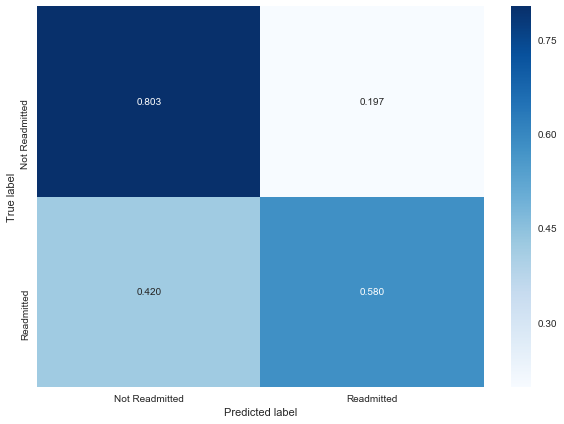

In [30]:
model_name = 'Random Forest Top 100'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

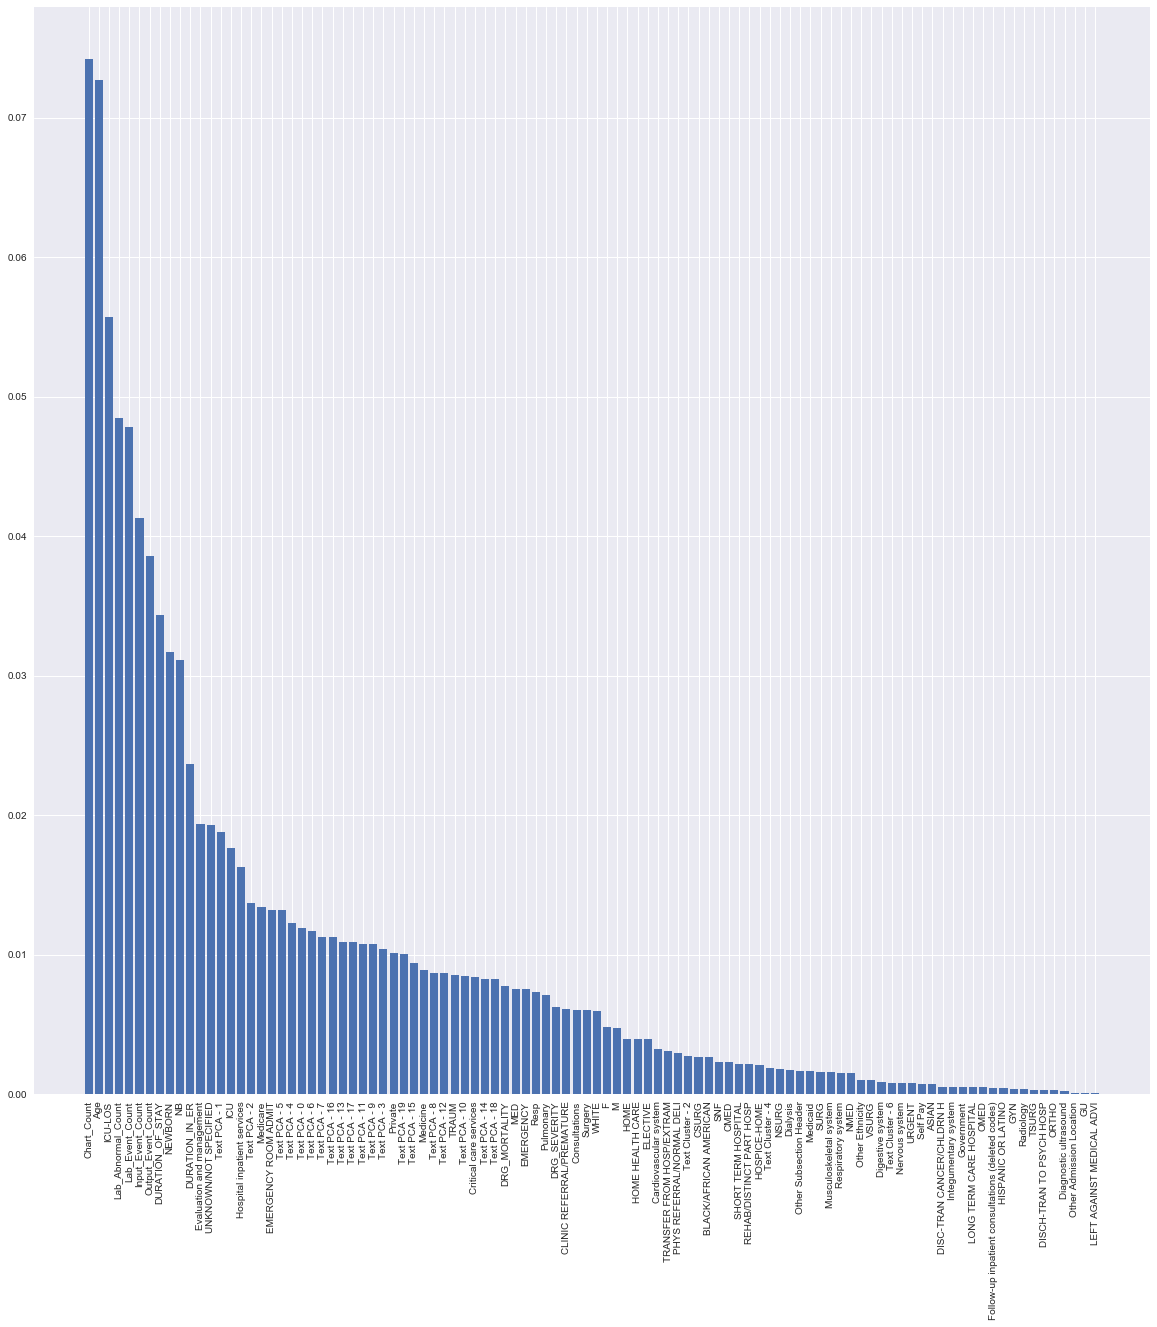

In [31]:
feature_importance_subdf = feature_importance_df[feature_importance_df[model_name].notnull()]
feature_importance_subdf = feature_importance_subdf.reset_index()
get_feature_importance(feature_importance_subdf[model_name], feature_importance_subdf['Features'])

## XGBoost

### Unbalanced

XGBoost - Train Accuracy: 0.8431
XGBoost - Train Precision: 0.9557
XGBoost - Train Recall: 0.1162
XGBoost - Train F1: 0.2072
XGBoost - Train AUC: 0.7909


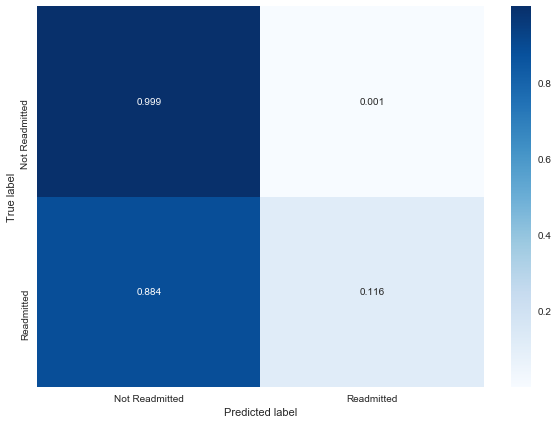

XGBoost - Test Accuracy: 0.8377
XGBoost - Test Precision: 0.9670
XGBoost - Test Recall: 0.1145
XGBoost - Test F1: 0.2048
XGBoost - Test AUC: 0.7888


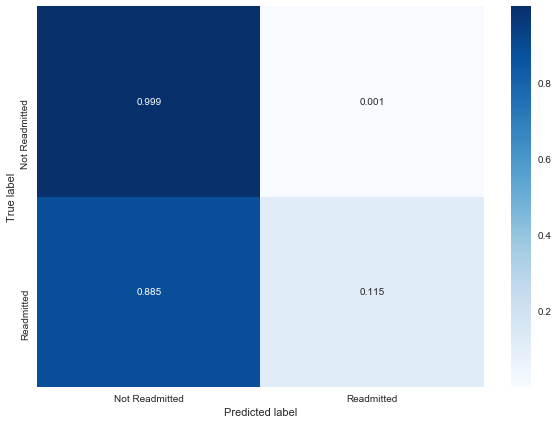

In [32]:
model_name = 'XGBoost'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

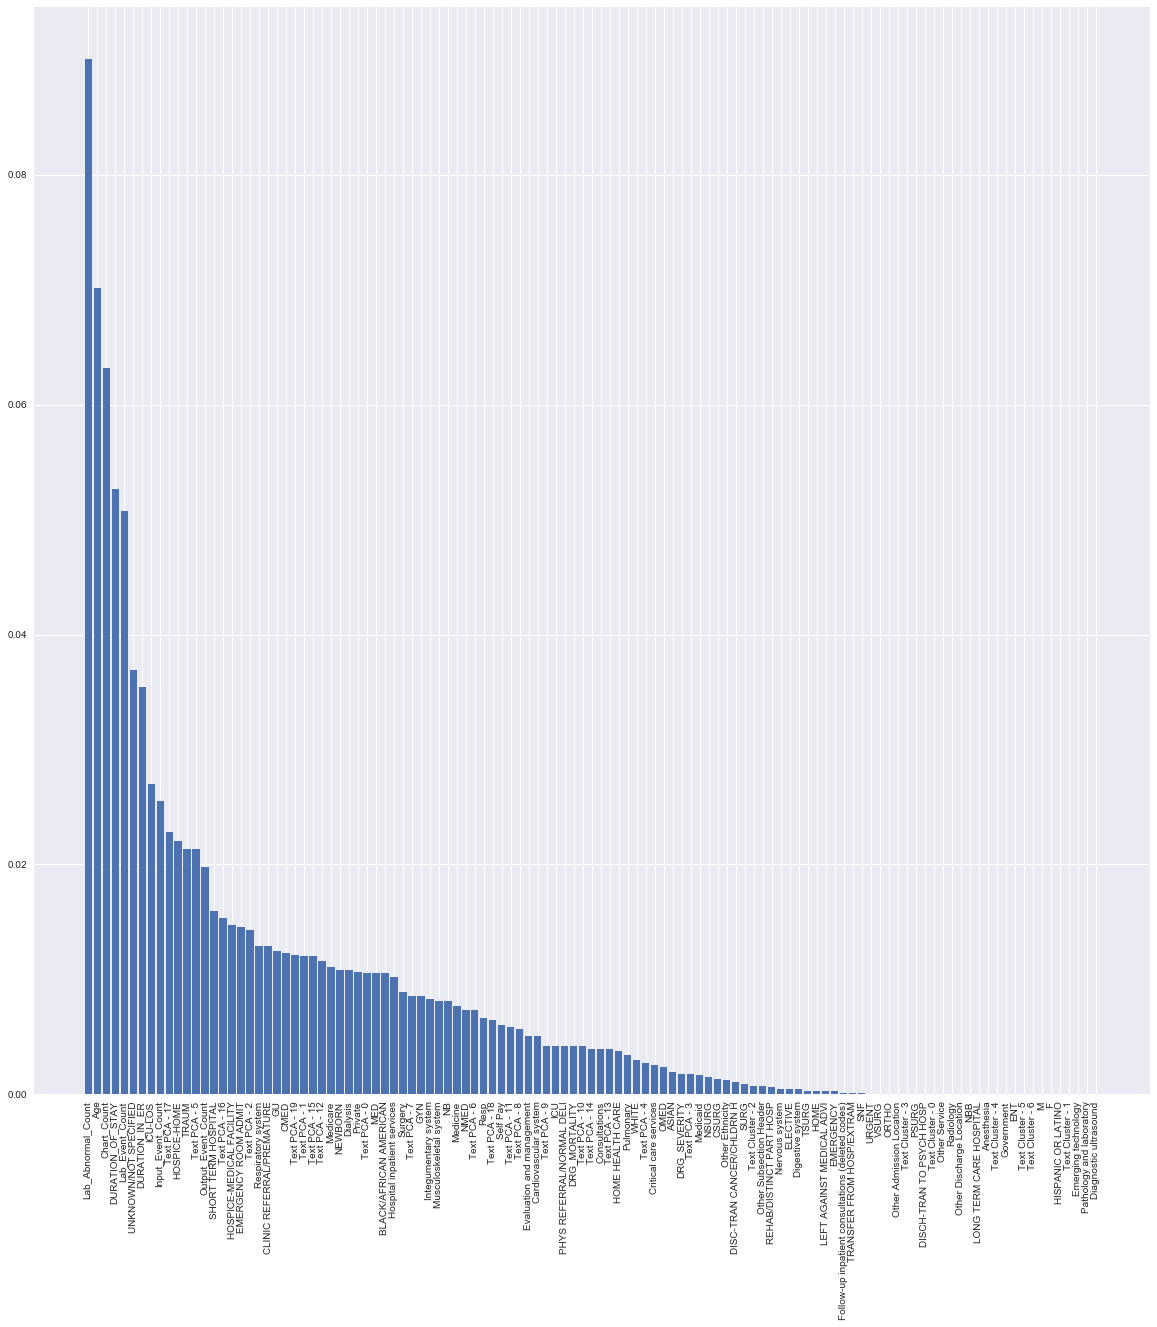

In [33]:
get_feature_importance(feature_importance_df[model_name], feature_importance_df['Features'])

### Balanced

XGBoost Balanced - Train Accuracy: 0.7612
XGBoost Balanced - Train Precision: 0.4092
XGBoost Balanced - Train Recall: 0.7958
XGBoost Balanced - Train F1: 0.5405
XGBoost Balanced - Train AUC: 0.8650


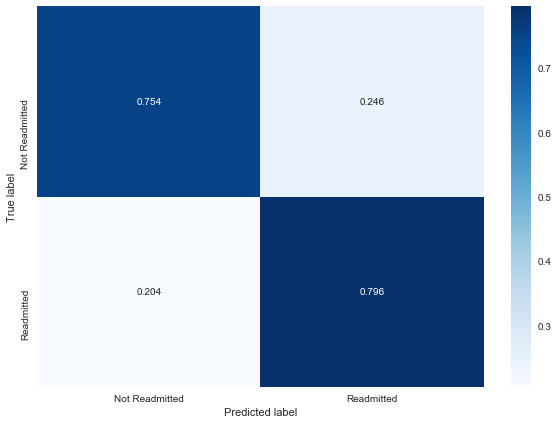

XGBoost Balanced - Test Accuracy: 0.7167
XGBoost Balanced - Test Precision: 0.3571
XGBoost Balanced - Test Recall: 0.6903
XGBoost Balanced - Test F1: 0.4707
XGBoost Balanced - Test AUC: 0.7949


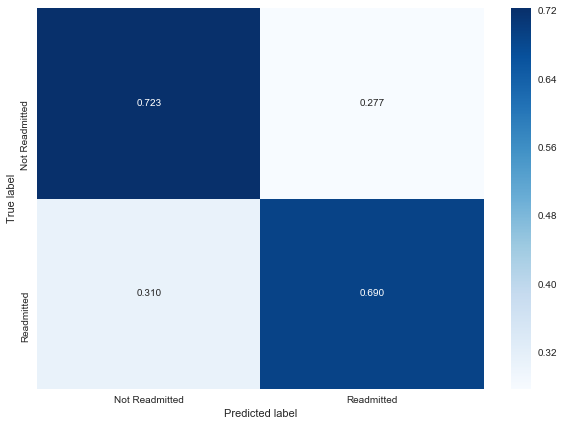

In [34]:
model_name = 'XGBoost Balanced'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

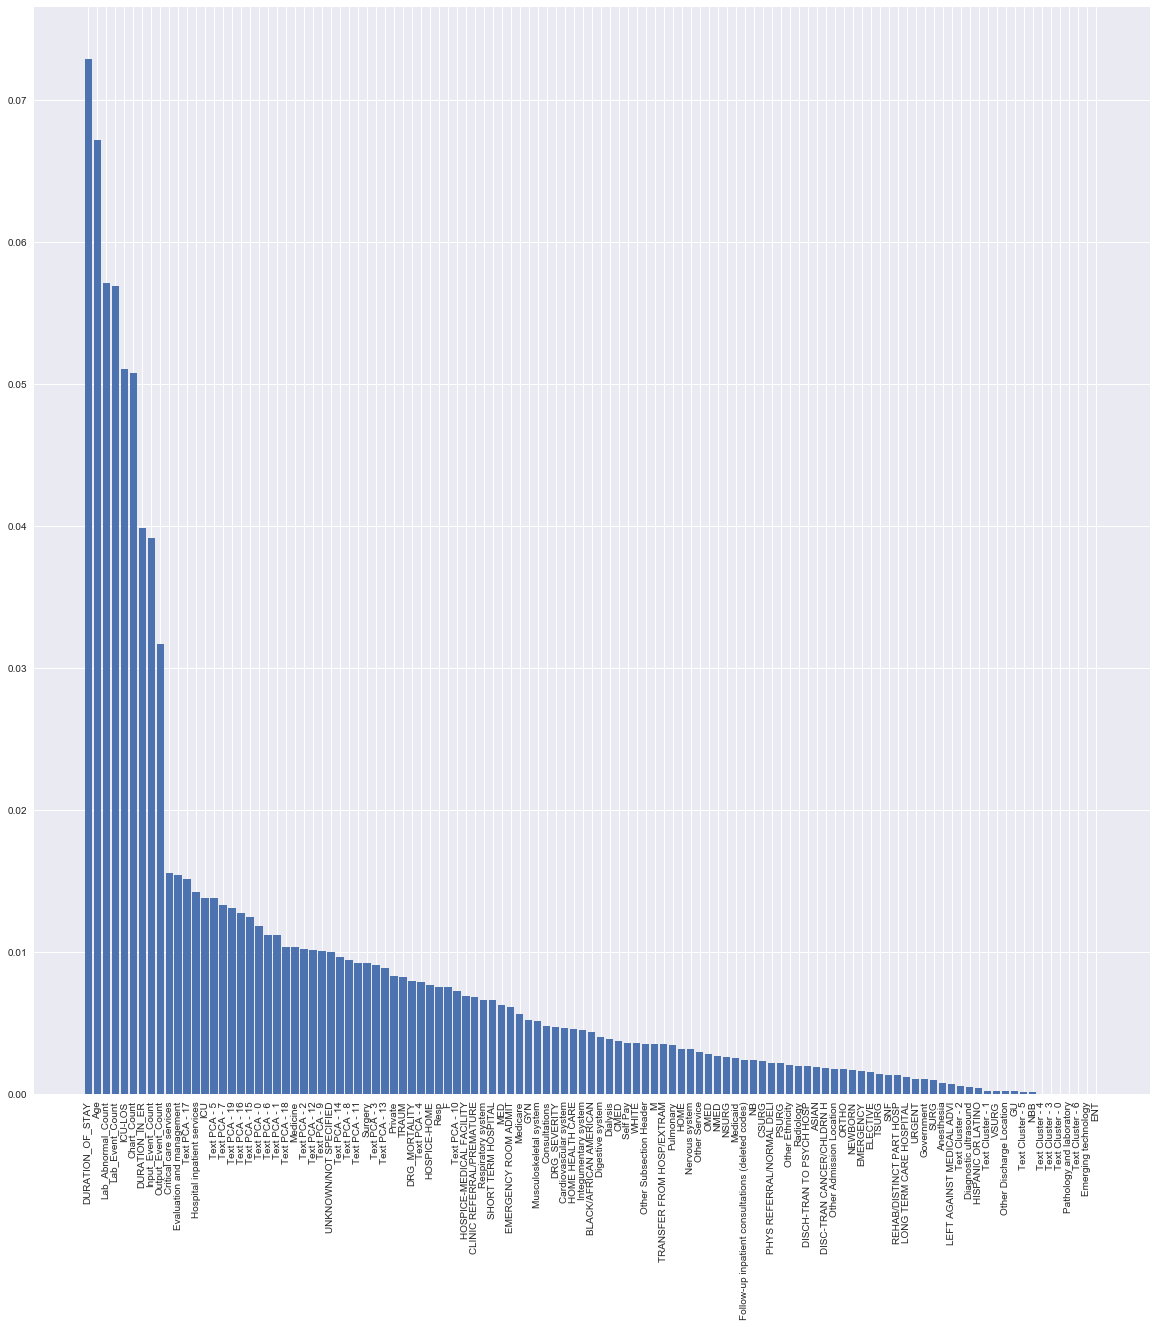

In [35]:
get_feature_importance(feature_importance_df[model_name], feature_importance_df['Features'])

 # Ensemble

In [36]:
def plot_model_output_corrplot(output):
    columns_corrplot = [column for column in test_predictions_df.columns if output in column and 'Blind' not in column]
    corrplot_df = test_predictions_df[columns_corrplot]
    corrplot_labels = [column.replace('_Test_{0}'.format(output, ''), '') for column in corrplot_df]
    sn.set(style="white")
    # Compute the correlation matrix
    corr = corrplot_df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sn.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sn.heatmap(corr, mask=mask, cmap=cmap, ax=ax, vmin=-1, xticklabels=corrplot_labels, yticklabels=corrplot_labels, annot=True)
    plt.title('Model {0} Correlation Matrix'.format(output))
    plt.show()

### Predictions

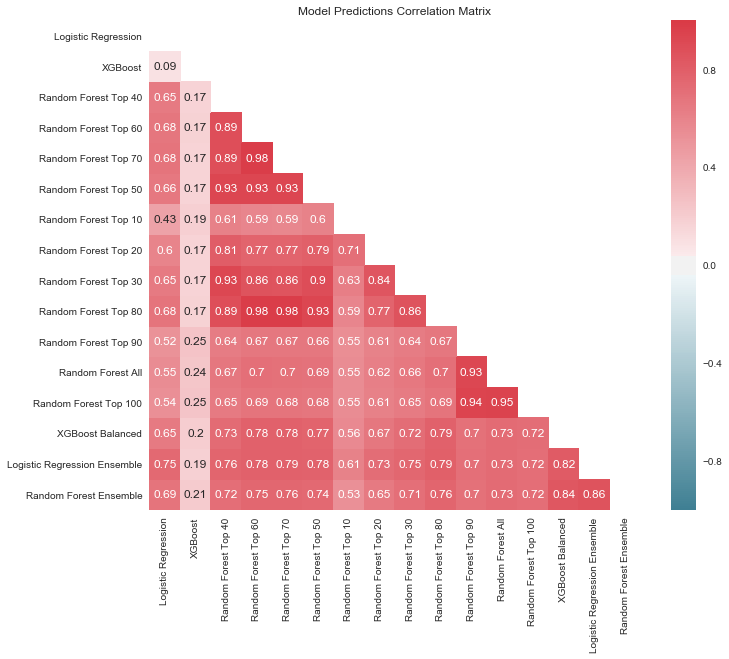

In [37]:
plot_model_output_corrplot('Predictions')

### Probabilities

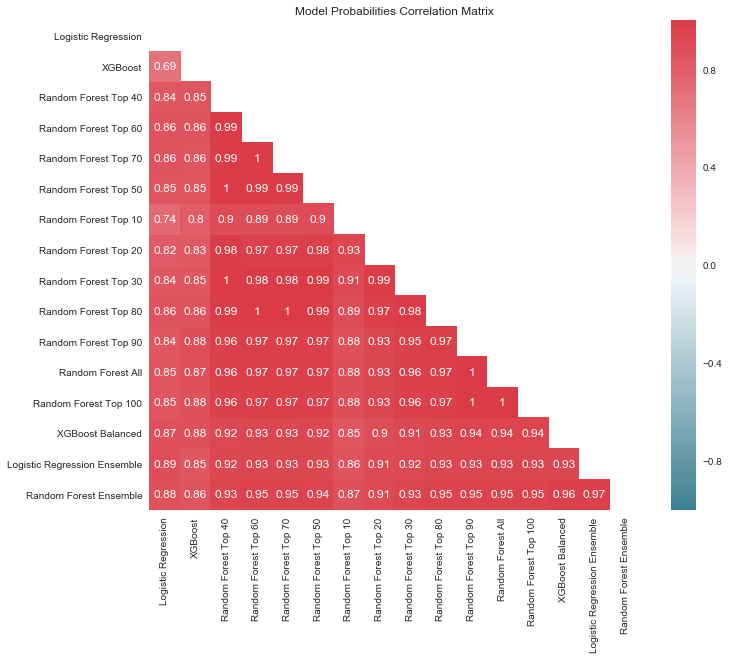

In [38]:
plot_model_output_corrplot('Probabilities')

### Choose Ensemble Models

In [39]:
ensemble_models = ['XGBoost Balanced', 'XGBoost', 'Logistic Regression', 'Random Forest Top 10',
                'Random Forest Top 90']
parameters_df['filter'] = parameters_df['Name'].apply(lambda x: x in ensemble_models)
ensemble_models_df = parameters_df[parameters_df['filter'] == True]
parameters_df = parameters_df.drop('filter', axis = 1)
ensemble_models_df.to_csv('ensemble_models.csv', index = False)

### Logistic Regression Ensemble

Logistic Regression Ensemble - Train Accuracy: 0.6969
Logistic Regression Ensemble - Train Precision: 0.3292
Logistic Regression Ensemble - Train Recall: 0.6914
Logistic Regression Ensemble - Train F1: 0.4460
Logistic Regression Ensemble - Train AUC: 0.7724


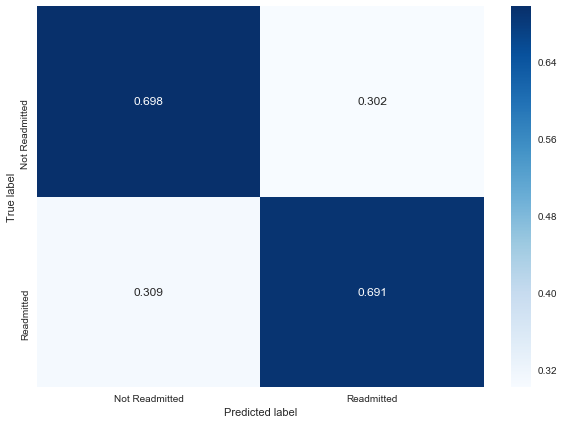

Logistic Regression Ensemble - Test Accuracy: 0.6946
Logistic Regression Ensemble - Test Precision: 0.3422
Logistic Regression Ensemble - Test Recall: 0.7300
Logistic Regression Ensemble - Test F1: 0.4659
Logistic Regression Ensemble - Test AUC: 0.7807


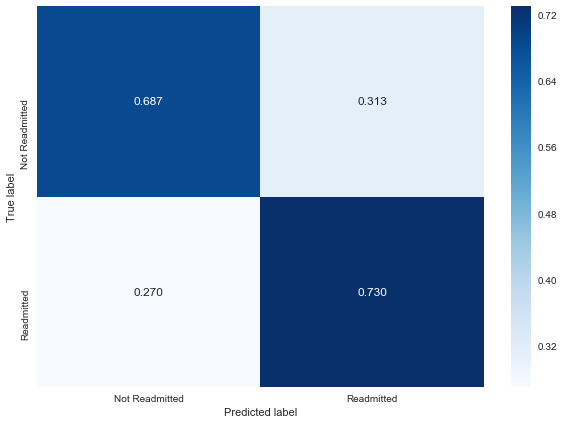

In [41]:
model_name = 'Logistic Regression Ensemble'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

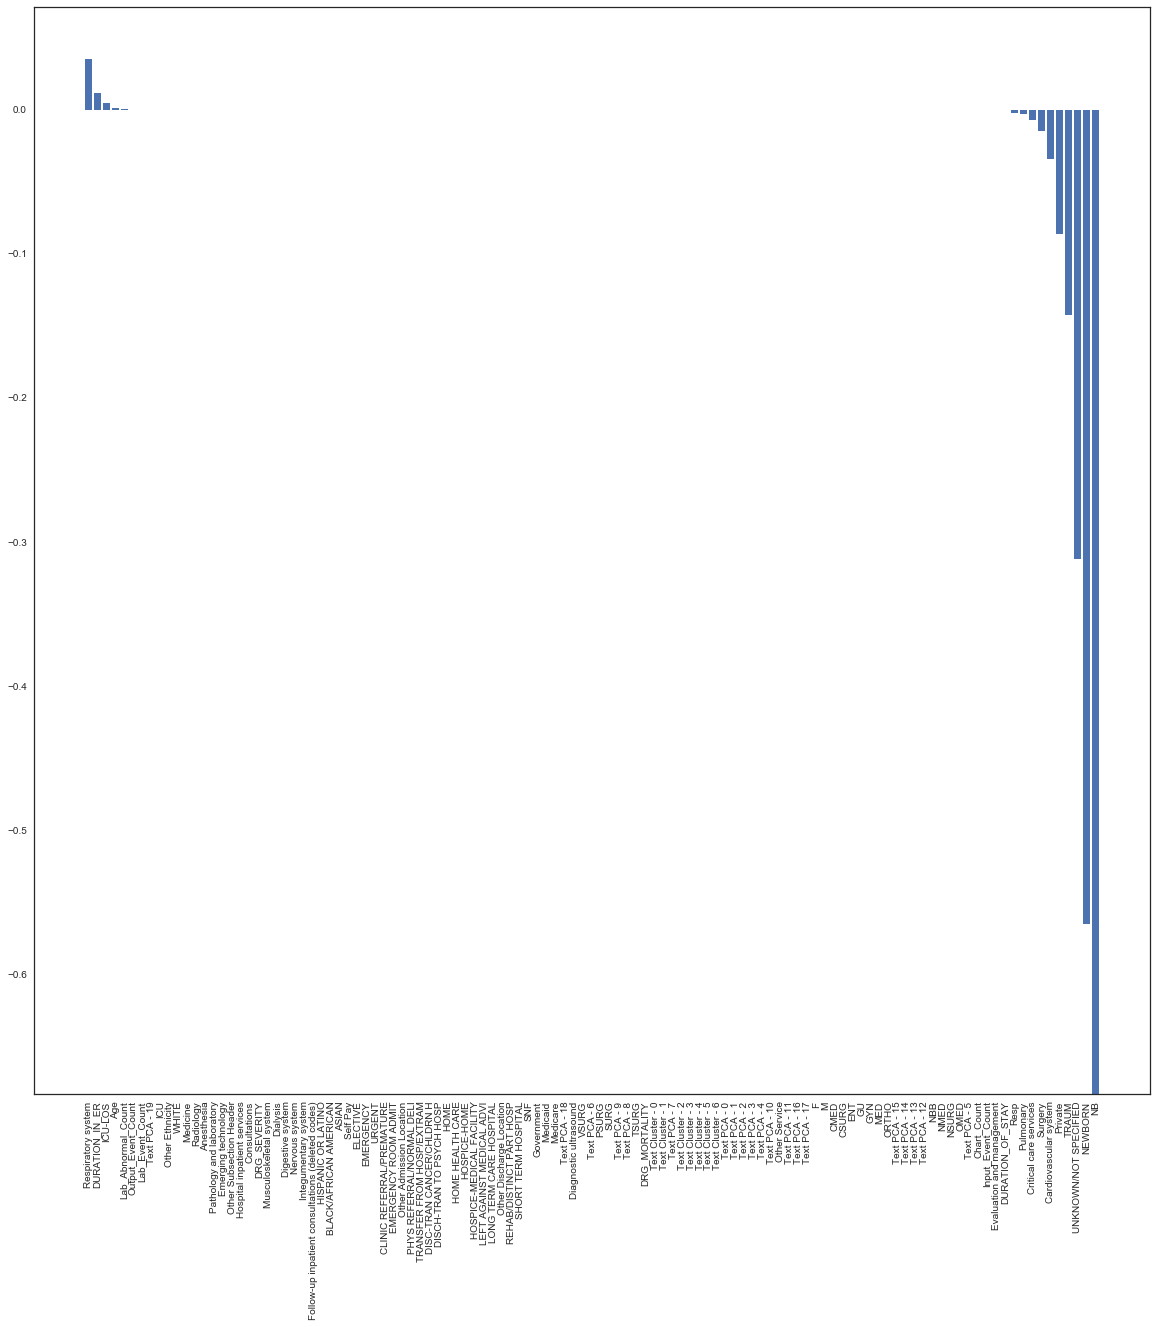

In [42]:
get_feature_importance(feature_importance_df[model_name], feature_importance_df['Features'])

### Random Forest Ensemble

Random Forest Ensemble - Train Accuracy: 0.7682
Random Forest Ensemble - Train Precision: 0.4164
Random Forest Ensemble - Train Recall: 0.7807
Random Forest Ensemble - Train F1: 0.5431
Random Forest Ensemble - Train AUC: 0.8571


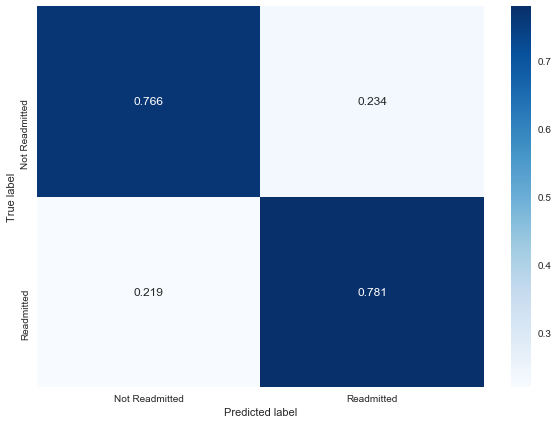

Random Forest Ensemble - Test Accuracy: 0.7215
Random Forest Ensemble - Test Precision: 0.3602
Random Forest Ensemble - Test Recall: 0.6779
Random Forest Ensemble - Test F1: 0.4704
Random Forest Ensemble - Test AUC: 0.7860


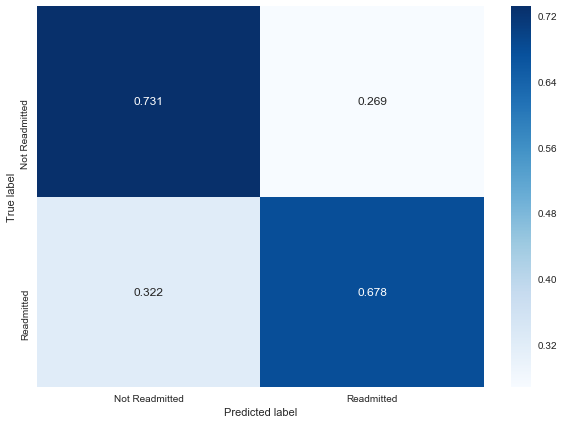

In [43]:
model_name = 'Random Forest Ensemble'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'], train_predictions_df[model_name + '_Train_Probabilities'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'], test_predictions_df[model_name + '_Test_Probabilities'],
                                   model_name + ' - Test', scores_df)

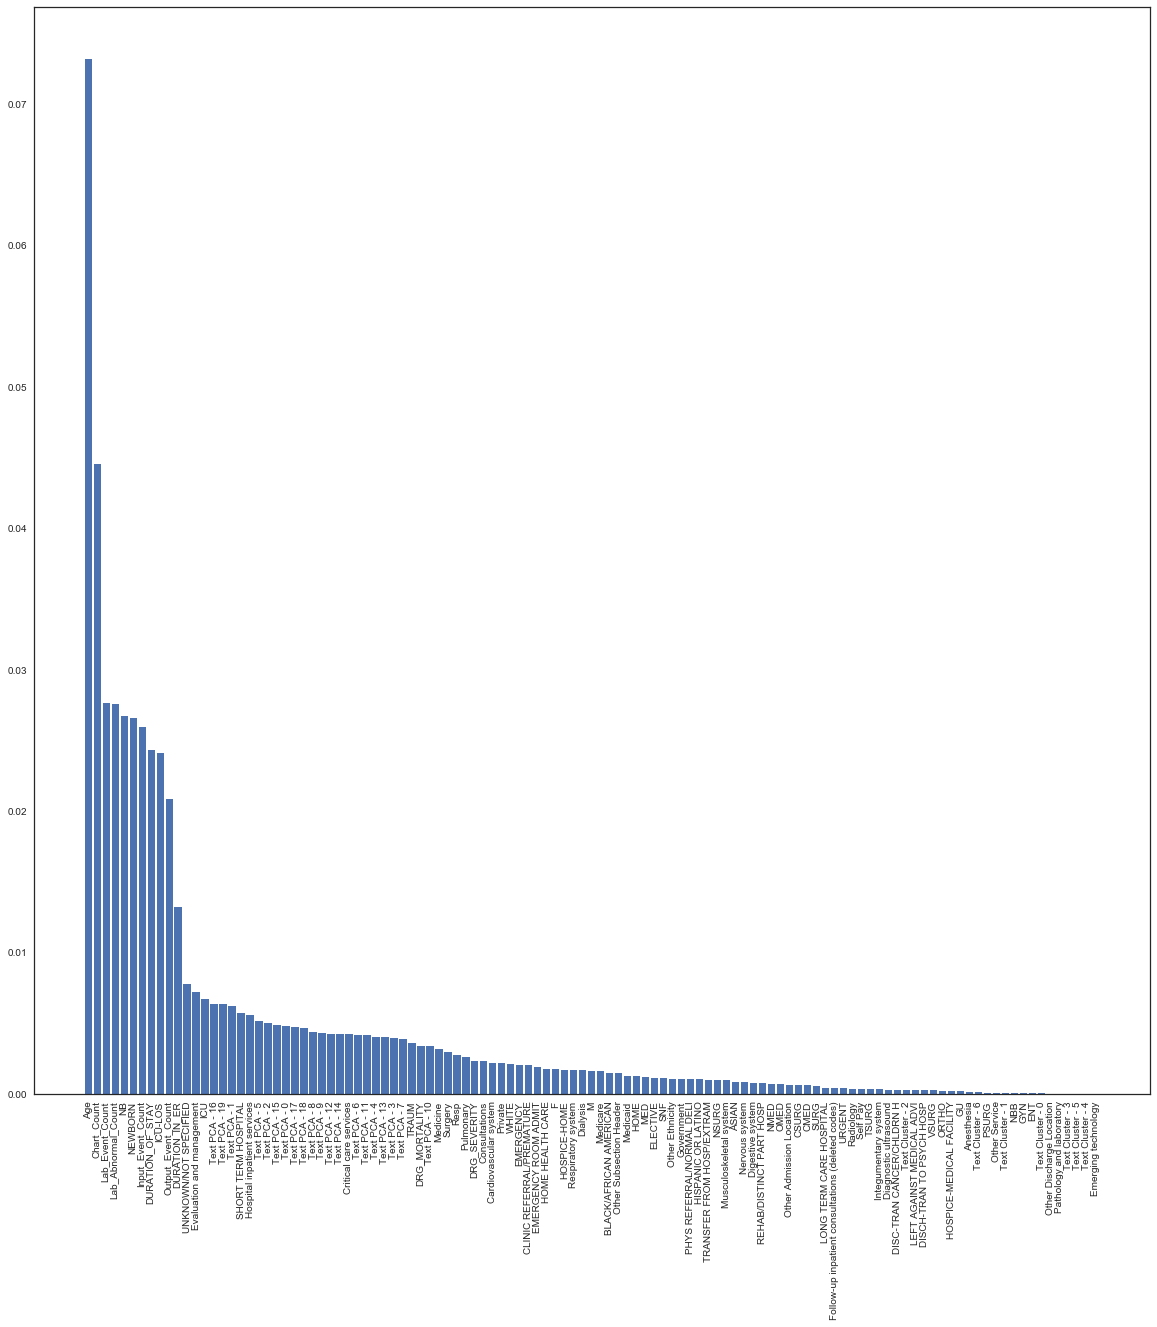

In [44]:
get_feature_importance(feature_importance_df[model_name], feature_importance_df['Features'])

## All Models

In [45]:
scores_df['TrainTestFlag'] = scores_df['Model'].apply(lambda x: 'Train' if 'Train' in x else 'Test')
scores_df['Model'] = scores_df['Model'].apply(lambda x: x.replace(' - Train', ''))
scores_df['Model'] = scores_df['Model'].apply(lambda x: x.replace(' - Test', ''))
scores_df_train = scores_df[scores_df['TrainTestFlag'] == 'Train'].drop('TrainTestFlag', axis = 1)
scores_df_test = scores_df[scores_df['TrainTestFlag'] == 'Test'].drop('TrainTestFlag', axis = 1)

### Training Scores

In [46]:
scores_df_train.sort_values('AUC', ascending = False)

,Model,Accuracy,Precision,Recall,F1,AUC
0,Random Forest Top 90,0.870533,0.590847,0.866297,0.702537,0.943523
0,Random Forest Top 100,0.861629,0.571620,0.861756,0.687324,0.938047
0,Random Forest All,0.849579,0.547194,0.856038,0.667629,0.929988
0,XGBoost Balanced,0.761219,0.409236,0.795829,0.540522,0.864978
0,Random Forest Ensemble,0.768194,0.416398,0.780693,0.543115,0.857109
0,Random Forest Top 80,0.690372,0.339004,0.794316,0.475199,0.818765
0,Random Forest Top 70,0.690787,0.339644,0.796502,0.476219,0.818392
0,Random Forest Top 60,0.690194,0.339273,0.797343,0.476004,0.818146
0,Random Forest Top 50,0.686483,0.336381,0.798184,0.473298,0.815697
0,Random Forest Top 40,0.673513,0.326870,0.802388,0.464512,0.813961


### Testing Scores

In [47]:
scores_df_test.sort_values('AUC', ascending = False)

,Model,Accuracy,Precision,Recall,F1,AUC
0,XGBoost Balanced,0.716728,0.357119,0.690306,0.470719,0.794912
0,Random Forest Top 100,0.762080,0.396176,0.579701,0.470681,0.790185
0,Random Forest Top 90,0.767779,0.403233,0.567990,0.471637,0.789782
0,Random Forest All,0.756619,0.389867,0.590761,0.469736,0.789433
0,XGBoost,0.837706,0.967033,0.114509,0.204770,0.788757
0,Random Forest Ensemble,0.721477,0.360180,0.677944,0.470429,0.786030
0,Random Forest Top 80,0.670189,0.327303,0.765127,0.458480,0.785689
0,Random Forest Top 70,0.668764,0.326310,0.765777,0.457621,0.784628
0,Random Forest Top 60,0.670307,0.327682,0.767079,0.459202,0.784362
0,Random Forest Top 50,0.665440,0.323310,0.762524,0.454088,0.781664


### AUC

In [48]:
def plot_roc(y, predictions, label):
    plt.figure(figsize=(20,20))
    
    models = [column for column in predictions.columns if 'Blind' not in column]
    # Compute fpr, tpr, thresholds and roc auc
    for model in models:
        prediction = predictions[model]
        fpr, tpr, thresholds = roc_curve(y, prediction)
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        ls = ':' if 'Ensemble' in model else '-'
        plt.plot(fpr, tpr, ls = ls, label=model + ' ROC curve (area = %0.3f)' % roc_auc)
        
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('{0} ROC Curves'.format(label))
    plt.legend(loc="lower right")

    plt.show()

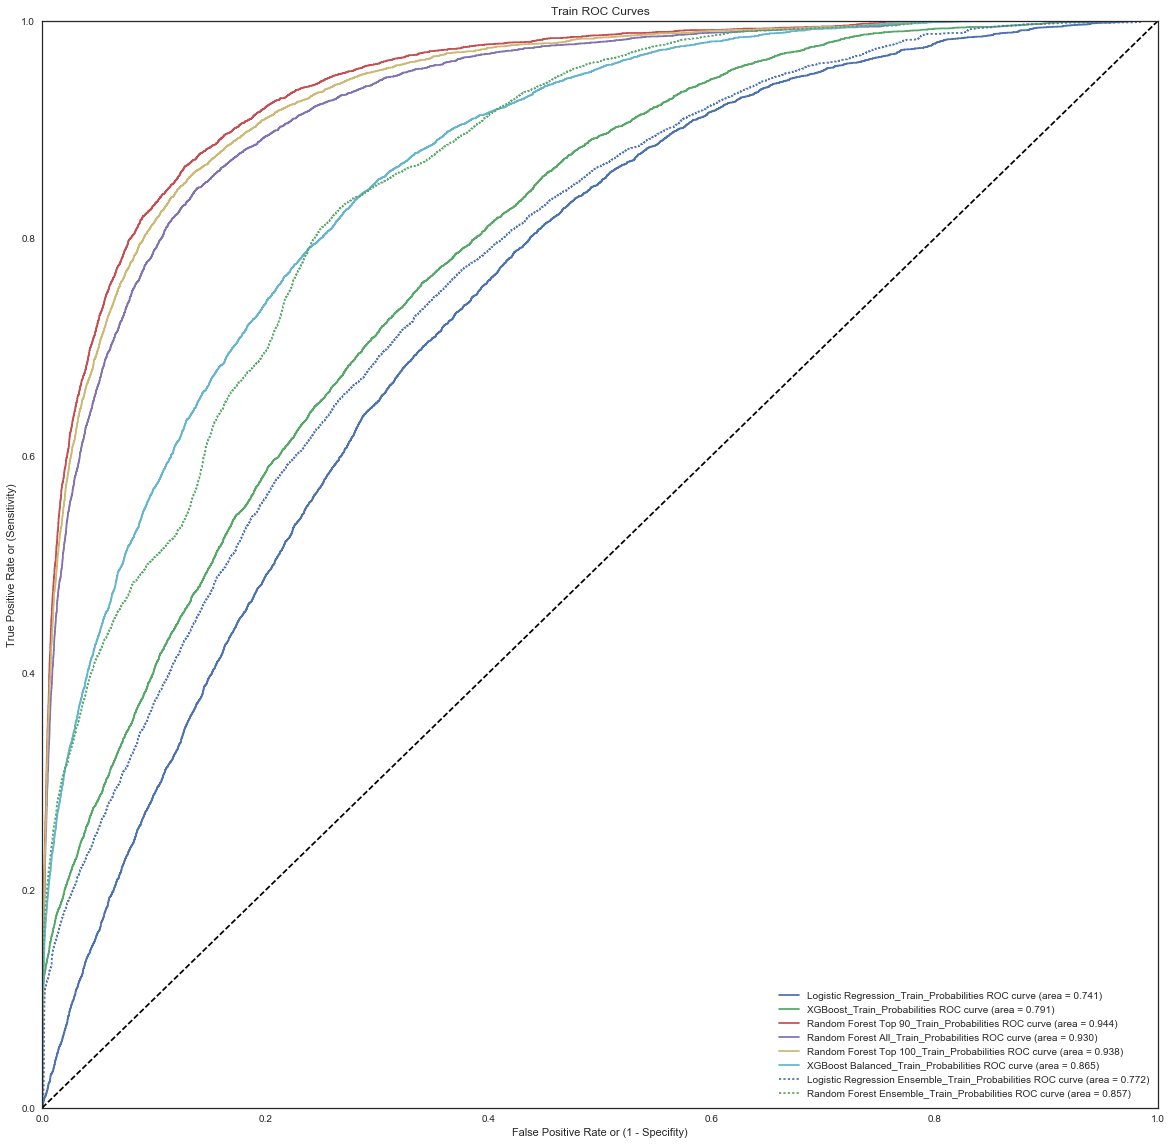

In [49]:
models_to_plot = ['XGBoost Balanced', 'Random Forest Top 100', 'Random Forest Top 90',
                 'Random Forest All', 'XGBoost', 'Logistic Regression', 'Logistic Regression Ensemble', 'Random Forest Ensemble']
train_probability_columns = [column for column in train_predictions_df.columns if 'Probabilities' in column and column.replace('_Train_Probabilities', '') in models_to_plot]
plot_roc(train_predictions_df['READMISSION'], train_predictions_df[train_probability_columns], 'Train')

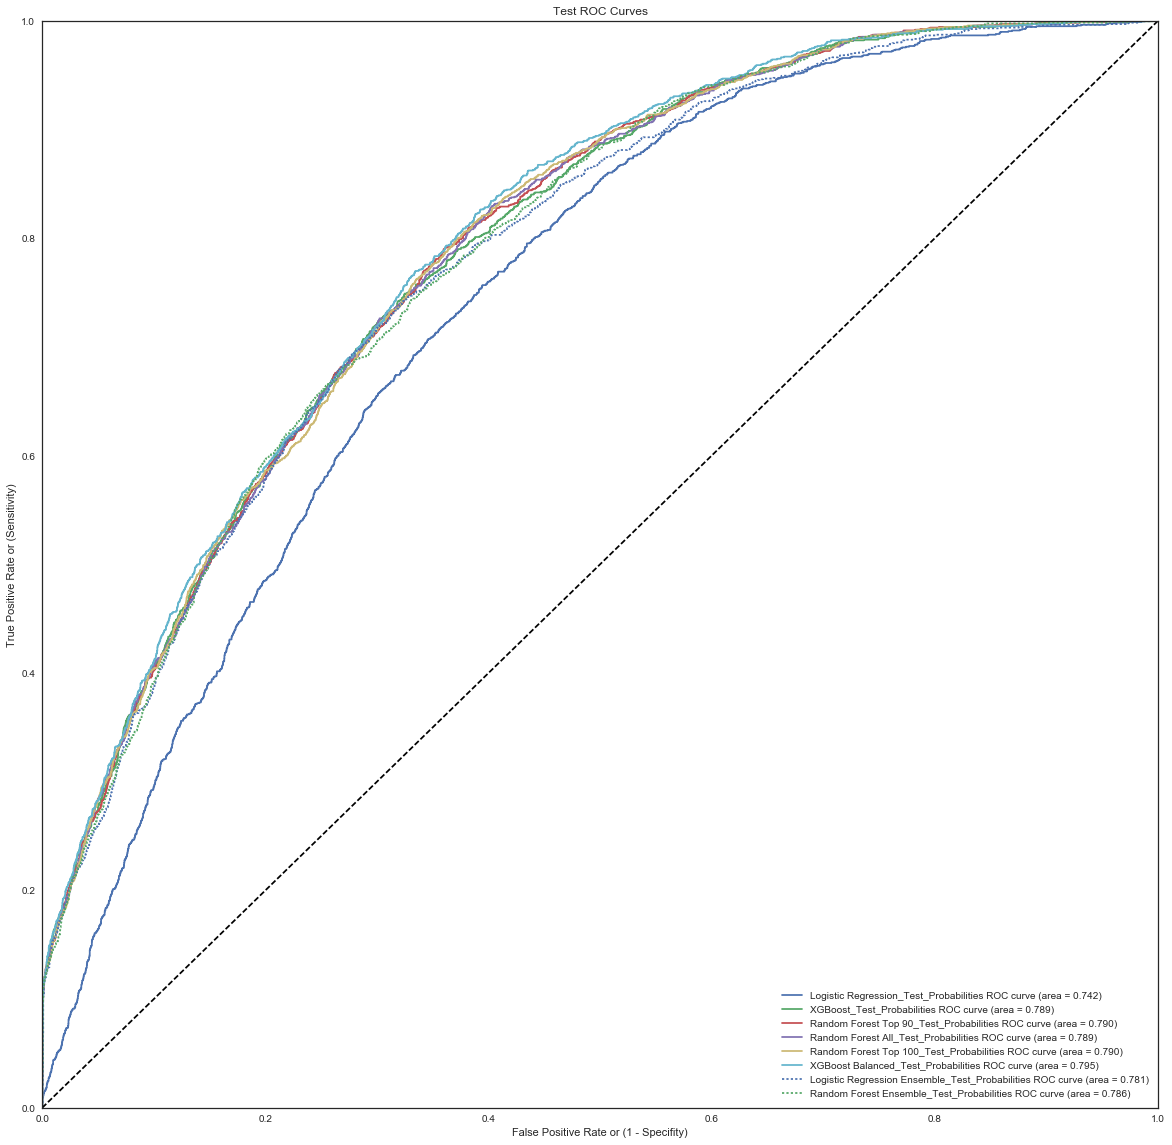

In [50]:
test_probability_columns = [column for column in test_predictions_df.columns if 'Probabilities' in column and column.replace('_Test_Probabilities', '') in models_to_plot]
plot_roc(test_predictions_df['READMISSION'], test_predictions_df[test_probability_columns], 'Test')

### Cost Effectiveness

In [51]:
def plot_cost_effectiveness(predictions, label):
    
    plt.figure(figsize=(20,20))
    
    PROBABILITY_OF_READMISSION = list(predictions.columns)
    
    models = [model.replace('_{0}_Probabilities'.format(label), '') for model in predictions.index]
    num_models = predictions.shape[0]
    for i in range(num_models):
        model_name = models[i]
        costs = predictions.iloc[i].tolist()
        
        ls = '--' if 'Blind' in model_name else '-'
        ls = ':' if 'Ensemble' in model_name else ls
        plot_title = '{0} Costs | min = ${1:,.0f}'.format(model_name, min(costs))
        plt.plot(PROBABILITY_OF_READMISSION, costs, label = plot_title, ls = ls)
    
    plt.xlabel('Probability of Readmission - Post Intervention')
    plt.ylabel('Minimum Program Cost')
    plt.title('{0} Minimum Program Costs'.format(label))
    plt.legend(loc="upper right")    
    plt.show()

In [52]:
models_to_plot = ['XGBoost Balanced', 'Random Forest Top 100', 'Random Forest Top 90',
                 'Random Forest All', 'XGBoost', 'Logistic Regression', 'Blind Guess All',
                 'Blind Guess None', 'Logistic Regression Ensemble', 'Random Forest Ensemble']

#### Train

In [53]:
train_costs_df = pd.read_csv('model_train_costs_dataset.csv')
train_costs_subdf = train_costs_df.drop(['Model', 'Probability of Readmission'], axis = 1)
train_costs_subdf['Total Cost'] = train_costs_subdf.sum(axis = 1)
train_costs_subdf['Min Cost'] = train_costs_subdf.min(axis = 1)
train_costs_subdf = train_costs_subdf[['Total Cost', 'Min Cost']]
train_costs_df = pd.concat([train_costs_df, train_costs_subdf], axis = 1)

In [54]:
train_costs_df.groupby(['Model'])['Min Cost'].min().sort_values()

Model
Random Forest Top 90_Train_Probabilities            20660841.0
Random Forest Top 100_Train_Probabilities           21478940.0
Random Forest All_Train_Probabilities               22416878.0
Random Forest Ensemble_Train_Probabilities          28177646.0
XGBoost Balanced_Train_Probabilities                28314954.0
Random Forest Top 80_Train_Probabilities            32071760.0
Random Forest Top 10_Train_Probabilities            32133624.0
Random Forest Top 70_Train_Probabilities            32184645.0
Random Forest Top 60_Train_Probabilities            32242268.0
Random Forest Top 50_Train_Probabilities            32437217.0
Random Forest Top 40_Train_Probabilities            32564709.0
Random Forest Top 30_Train_Probabilities            32709012.0
Random Forest Top 20_Train_Probabilities            33061217.0
XGBoost_Train_Probabilities                         33278252.0
Logistic Regression Ensemble_Train_Probabilities    35093632.0
Logistic Regression_Train_Probabilities          

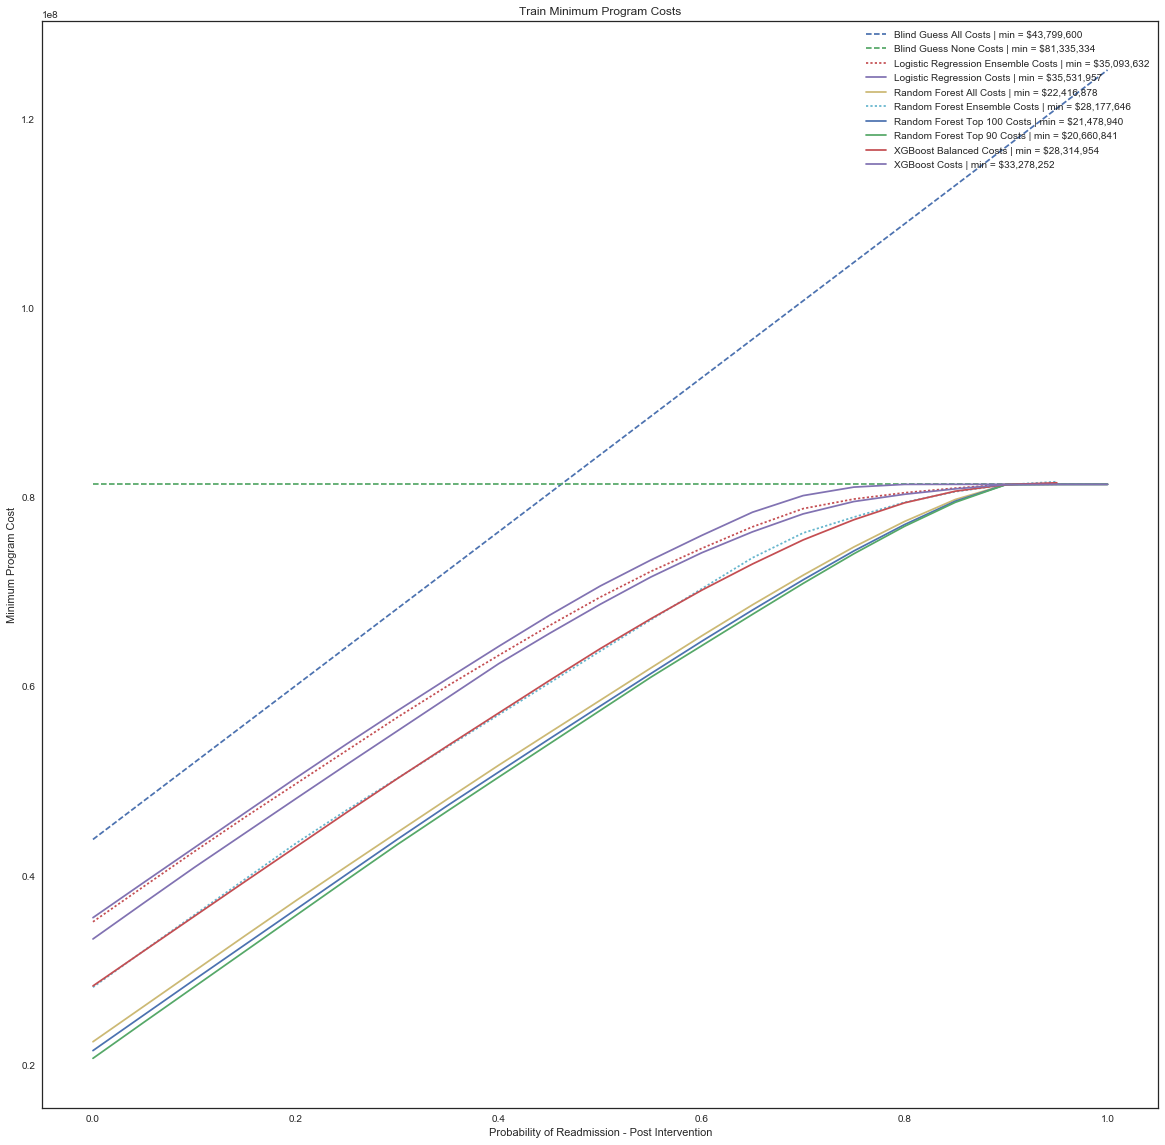

In [55]:
train_costs_df['filter'] = train_costs_df['Model'].apply(lambda x: x.replace('_Train_Probabilities' ,'')in models_to_plot)
train_costs_df = train_costs_df[train_costs_df['filter'] == True]
train_costs_df = train_costs_df.drop('filter', axis = 1)
train_costs_graph_df = train_costs_df.pivot(index='Model', columns = 'Probability of Readmission', values='Min Cost')
plot_cost_effectiveness(train_costs_graph_df, 'Train')

#### Test

In [56]:
test_costs_df = pd.read_csv('model_test_costs_dataset.csv')
test_costs_subdf = test_costs_df.drop(['Model', 'Probability of Readmission'], axis = 1)
test_costs_subdf['Total Cost'] = test_costs_subdf.sum(axis = 1)
test_costs_subdf['Min Cost'] = test_costs_subdf.min(axis = 1)
test_costs_subdf = test_costs_subdf[['Total Cost', 'Min Cost']]
test_costs_df = pd.concat([test_costs_df, test_costs_subdf], axis = 1)

In [57]:
test_costs_df.groupby(['Model'])['Min Cost'].min().sort_values()

Model
XGBoost Balanced_Test_Probabilities                 8404875.0
Random Forest Ensemble_Test_Probabilities           8474495.0
Random Forest Top 100_Test_Probabilities            8504661.0
Random Forest Top 90_Test_Probabilities             8509124.0
XGBoost_Test_Probabilities                          8524516.0
Random Forest Top 80_Test_Probabilities             8537574.0
Random Forest Top 70_Test_Probabilities             8562448.0
Random Forest All_Test_Probabilities                8566952.0
Random Forest Top 60_Test_Probabilities             8609886.0
Random Forest Top 50_Test_Probabilities             8674944.0
Random Forest Top 40_Test_Probabilities             8688473.0
Random Forest Top 30_Test_Probabilities             8689889.0
Logistic Regression Ensemble_Test_Probabilities     8741384.0
Random Forest Top 20_Test_Probabilities             8772079.0
Logistic Regression_Test_Probabilities              8821421.0
Random Forest Top 10_Test_Probabilities             8964346.0
Bl

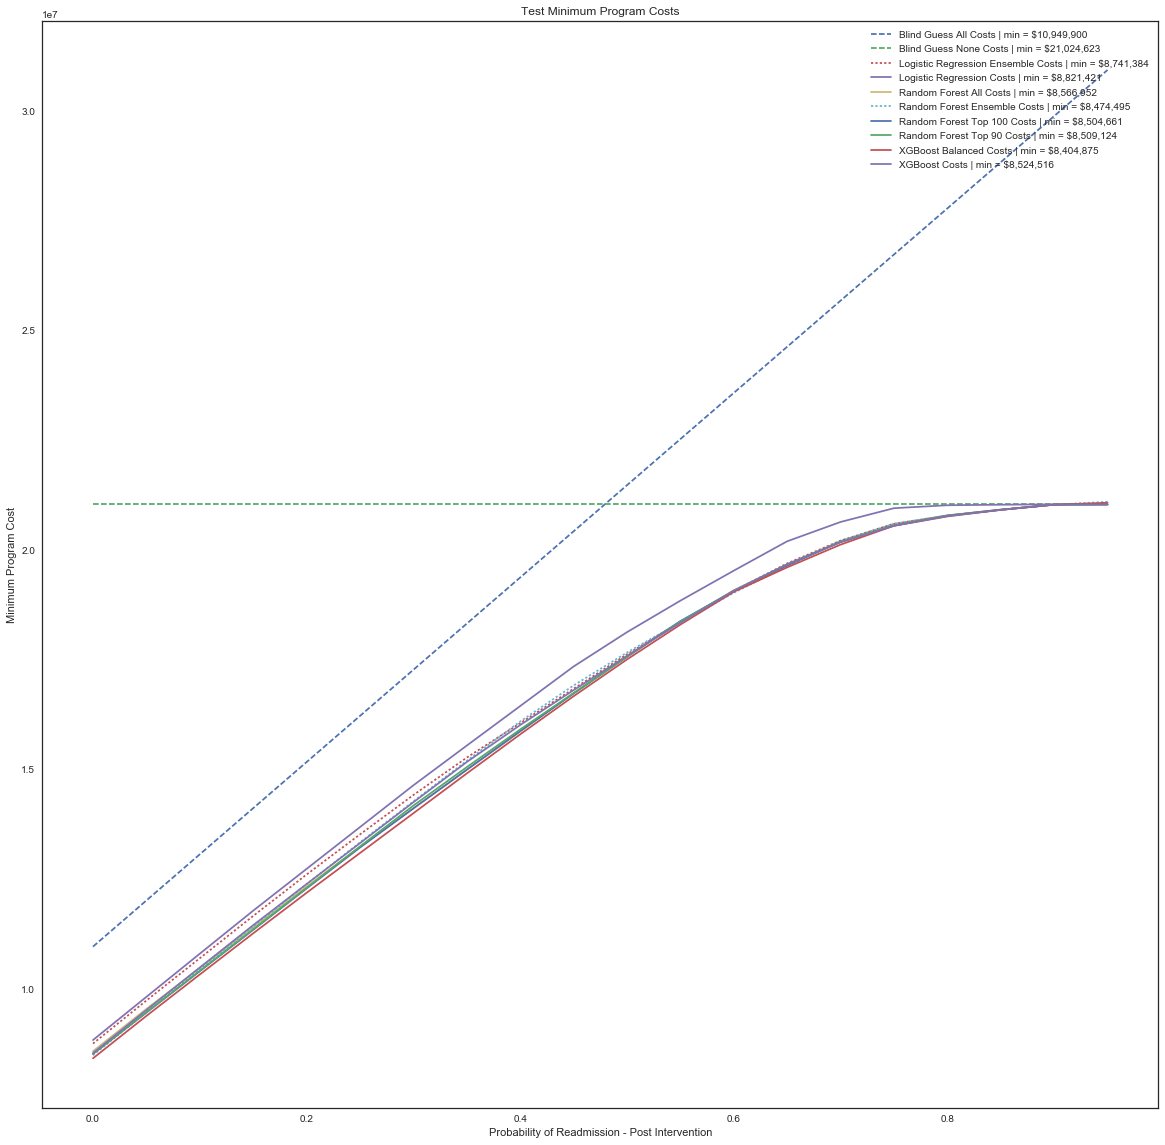

In [58]:
test_costs_df['filter'] = test_costs_df['Model'].apply(lambda x: x.replace('_Test_Probabilities' ,'')in models_to_plot)
test_costs_df = test_costs_df[test_costs_df['filter'] == True]
test_costs_df = test_costs_df.drop('filter', axis = 1)
test_costs_graph_df = test_costs_df.pivot(index='Model', columns = 'Probability of Readmission', values='Min Cost')
plot_cost_effectiveness(test_costs_graph_df, 'Test')